<a href="https://colab.research.google.com/github/deep1003/deep1003/blob/master/ai_patent_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Colab 단축키
# Ctrl + S (저장)
# Ctrl + Enter (셀하나 실행)
# Ctrl + Shift + Enter (선택한 코드만 실행)
# Ctrl + F9 (전체실행)
# Ctrl + F8 (현재 셀 포함 이전 전체 실행)
# Ctrl + F10 (현재 셀 포함 이후 전체 실행)
# Ctrl + / (전체 주석처리 & 해제)

In [3]:
# 필요한 패키지 설치 (최초 한 번만)
!pip install pandas numpy networkx matplotlib python-louvain pyvis pycountry rapidfuzz adjustText

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.1 MB/s eta 0:00:00


In [4]:
# 1. Google Drive 마운트 (파일 읽고/쓰기 위해서)
from google.colab import drive
drive.mount('/content/drive') # (구글 드라이브 설치후 보통 G:\ 를 의미함)

# 2. 데이터 디렉토리 경로 설정
base_dir = '/content/drive/MyDrive/data1' # (실제 csv 파일이 있는 위치)


Mounted at /content/drive


In [59]:
!ls /content/drive/MyDrive/data1


'2. 특허 분류_알고리즘과 모델_updated_0714.xlsx'
 36.NLP_1.csv
 36.NLP_2.csv
 37.Diaglogue.csv
 38.IE.csv
 39.MachineTranslation.csv
 40.Morphology.csv
 41.NLG.csv
'42.NLP(General)_1.csv'
'42.NLP(General)_2.csv'
'42.NLP(General)_3.csv'
'42.NLP(General)_4.csv'
 43.Semantics.csv
 44.SentimentAnalysis.csv
 53.Speech-to-Speech.csv
 54.SpeechSynthesis.csv
 9.DeepLearning_1.csv
 9.DeepLearning_2.csv
 9.DeepLearning_3.csv
 9.DeepLearning_4.csv
 9.DeepLearning_5.csv
 ai_patent_1.ipynb
 combined_foundation_llm.csv
 data1.zip
 data_patent_analysis_1.R
 data_patent_analysis_1_update_0717.R
 data_patent_analysis_1_update.R
 Deel_Learning_table_year_country.xlsx
 df_expl2_with_technology_type.csv
 df_expl2_with_technology_type_patentsberta.csv
 df_expl3_with_technology_type.csv
 df_expl3_with_technology_type_patentsberta.csv
 images
 patent_by_PTO_type.csv
 patent_counts_by_country_by_year.csv
 patent_counts_by_type_by_year.csv
 processed_inventors.csv
 table_year_country.csv
 top_cited_invent

In [63]:
import nbformat, glob, os

TARGET_GLOB = "notebooks/**/*.ipynb"   # 필요하면 패턴 수정 (예: "*.ipynb")
count_cleaned = 0

for path in glob.glob(TARGET_GLOB, recursive=True):
    try:
        nb = nbformat.read(path, as_version=4)
    except Exception as e:
        print(f"[SKIP: read error] {path} -> {e}")
        continue

    changed = False

    if 'widgets' in nb.metadata:
        nb.metadata.pop('widgets')
        changed = True

    for cell in nb.cells:
        md = cell.get('metadata', {})
        if 'widgets' in md:
            md.pop('widgets')
            changed = True

    if changed:
        nbformat.write(nb, path)
        count_cleaned += 1
        print(f"[Cleaned] {path}")

print(f"\nDone. Cleaned files: {count_cleaned}")



Done. Cleaned files: 0


In [5]:
# Ctrl + F10를 하면 이 셀부터 전체 실행
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import pycountry #iso 공식 국가 코드 명칭이 있는 DB

In [6]:
# 셀 1: Google Drive에서 CSV 파일 목록 조회 및 필터링
import os       # OS 경로 조작 모듈
from glob import glob    # 파일 패턴 매칭용 glob 함수

base_dir = '/content/drive/My Drive/data1'  # 데이터가 저장된 구글 드라이브 경로

# '9.' 또는 특정 숫자로 시작하는 파일만 선택하기 위한 접두사(tuple 형태)
# 예: "9.DeelLearning_1.csv" 등
prefixes = ('36','37','38','39','40','41','42','43','44')
# base_dir 내 모든 CSV 파일을 찾아 리스트로 수집
all_csv = glob(os.path.join(base_dir, '*.csv'))
# basename 기준으로 prefixes 중 하나로 시작하는 파일만 필터링
csv_files = [
    f for f in all_csv
    if os.path.basename(f).startswith(prefixes)
]

# 찾은 파일 개수 및 파일명 출력
print(f'찾은 파일 {len(csv_files)}개:')
for f in csv_files:
    print('  -', os.path.basename(f))


찾은 파일 13개:
  - 39.MachineTranslation.csv
  - 37.Diaglogue.csv
  - 40.Morphology.csv
  - 38.IE.csv
  - 43.Semantics.csv
  - 42.NLP(General)_1.csv
  - 42.NLP(General)_3.csv
  - 42.NLP(General)_2.csv
  - 42.NLP(General)_4.csv
  - 44.SentimentAnalysis.csv
  - 36.NLP_1.csv
  - 36.NLP_2.csv
  - 41.NLG.csv


In [7]:
# 셀 2: CSV 파일 읽기 및 중복 제거
import pandas as pd   # 데이터 처리용 pandas 불러오기

df_list = []  # 개별 CSV DataFrame을 담을 리스트

# 각 파일별로 여러 인코딩 시도하면서 읽기
for f in csv_files:
    for enc in ('utf-8', 'cp949', 'latin1'):
        try:
            # 지정된 인코딩으로 CSV 읽기
            df = pd.read_csv(f, encoding=enc)
            print(f'{os.path.basename(f)} 읽기 성공 (encoding={enc})')
            df_list.append(df)  # 읽은 DataFrame을 리스트에 추가
            break               # 성공 시 다음 파일로
        except Exception:
            continue            # 실패하면 다음 인코딩 시도

# 리스트에 모인 DataFrame을 하나로 합치고 완전 중복 행 제거
combined_df1 = pd.concat(df_list, ignore_index=True).drop_duplicates()
print(f'▶︎ 병합 후 총 행 수: {len(combined_df1)}')


39.MachineTranslation.csv 읽기 성공 (encoding=cp949)
37.Diaglogue.csv 읽기 성공 (encoding=cp949)
40.Morphology.csv 읽기 성공 (encoding=cp949)
38.IE.csv 읽기 성공 (encoding=cp949)
43.Semantics.csv 읽기 성공 (encoding=cp949)
42.NLP(General)_1.csv 읽기 성공 (encoding=cp949)
42.NLP(General)_3.csv 읽기 성공 (encoding=cp949)
42.NLP(General)_2.csv 읽기 성공 (encoding=cp949)
42.NLP(General)_4.csv 읽기 성공 (encoding=cp949)
44.SentimentAnalysis.csv 읽기 성공 (encoding=cp949)
36.NLP_1.csv 읽기 성공 (encoding=cp949)
36.NLP_2.csv 읽기 성공 (encoding=cp949)
41.NLG.csv 읽기 성공 (encoding=cp949)
▶︎ 병합 후 총 행 수: 46807


In [8]:
combined_df1.shape

(46807, 45)

In [9]:
combined_df1.columns

Index(['국가코드', 'DB종류', '특허/실용 구분', '문헌종류 코드', '발명의 명칭', '발명의 명칭-번역문', '요약',
       '요약-번역문', '대표청구항', '대표청구항-번역문', '독립청구항[KR,JP,US,CN,EP,IN]',
       '독립청구항-번역문[JP,US,CN,EP]', '청구항 수', '출원번호', '출원일', '공개번호', '공개일', '등록번호',
       '등록일', '출원인', '발명자', '인용 문헌 수(B1)', '인용 문헌번호(B1)', '피인용 문헌 수(F1)',
       '피인용 문헌번호(F1)', 'WIPS패밀리 ID', 'WIPS패밀리 문헌번호(출원기준)',
       'WIPS패밀리 문헌 수(출원기준)', '상태정보[KR,JP,US,EP,CN,CA,AU]',
       '현재권리자[KR,JP,US,CN,CA,AU]', '출원인 수', '출원인 국적', '출원인 대표명화 코드',
       '출원인 대표명화 영문명', '발명자 국적', '발명자 수', 'Current CPC Main',
       'Current CPC All', 'Current IPC Main', 'Current IPC All',
       'Original CPC Main', 'Original CPC All', 'Original IPC Main',
       'Original IPC All', 'Wintelips key'],
      dtype='object')

In [10]:
# 셀 3: 컬럼명 매핑 (한글 → 영문)
import pandas as pd  # pandas 데이터프레임 활용

# 1) combined_df1에 컬럼명 매핑 적용
orig = combined_df1.columns.tolist()  # 기존 컬럼명 목록
# 영문 컬럼명 리스트와 원래 한글명 매핑
new = [
  "PTO_id",                # 국가코드
  "PTO_type",              # DB종류
  "patent_kind",           # 특허/실용 구분
  "pub_type_code",         # 문헌종류 코드
  "title",                 # 발명의 명칭
  "title_en",              # 발명의 명칭-번역문
  "abstract",              # 요약
  "abstract_en",           # 요약-번역문
  "claim_main",            # 대표청구항
  "claim_main_en",         # 대표청구항-번역문
  "claims_indep",          # 독립청구항[KR,JP,US,CN,EP,IN]
  "claims_indep_en",       # 독립청구항-번역문[JP,US,CN,EP]
  "num_claims",            # 청구항 수
  "appl_id",               # 출원번호
  "appl_date",             # 출원일
  "pub_id",                # 공개번호
  "pub_date",               # 공개일
  "grant_id",               # 등록번호
  "grant_date",             # 등록일
  "applicant",              # 출원인
  "inventor",               # 발명자
  "citations_count",        # 인용 문헌 수(B1)
  "citation_ids",           # 인용 문헌번호(B1)
  "cited_by_count",         # 피인용 문헌 수(F1)
  "cited_by_ids",           # 피인용 문헌번호(F1)
  "wips_family_id",         # WIPS패밀리 ID
  "wips_family_pub_ids",   # WIPS패밀리 문헌번호(출원기준)
  "wips_family_pub_count", # WIPS패밀리 문헌 수(출원기준)
  "status_info",           # 상태정보[KR,JP,US,EP,CN,CA,AU]
  "current_owner",         # 현재권리자[KR,JP,US,CN,CA,AU]
  "num_applicants",        # 출원인 수
  "applicant_nat",         # 출원인 국적
  "applicant_main_code",   # 출원인 대표명화 코드
  "applicant_main_name_en",# 출원인 대표명화 영문명
  "inventor_nat",          # 발명자 국적
  "num_inventors",         # 발명자 수
  "cpc_main",              # Current CPC Main
  "cpc_all",               # Current CPC All
  "ipc_main",              # Current IPC Main
  "ipc_all",               # Current IPC All
  "orig_cpc_main",         # Original CPC Main
  "orig_cpc_all",          # Original CPC All
  "orig_ipc_main",         # Original IPC Main
  "orig_ipc_all",          # Original IPC All
  "wintelips_key"          # Wintelips key
]
# 컬럼 개수 일치 확인 후 적용
assert len(orig) == len(new), "컬럼 개수 불일치"
combined_df1.columns = new  # 컬럼명 변경 적용

# 2) 정렬된 결과를 combined_df에 저장
#    - inventor_nat 컬럼 값 역순으로 정렬한 결과를 combined_df 변수에 할당
if 'inventor_nat' in combined_df1.columns:
    combined_df = combined_df1.sort_values(
        by='inventor_nat', ascending=False
    ).reset_index(drop=True)
else:
    combined_df = combined_df1.copy()

In [11]:
# 중간 확인
display(combined_df[['appl_id', 'applicant', 'applicant_nat', 'inventor', 'inventor_nat', 'cited_by_count', 'appl_date']].head())

,appl_id,applicant,applicant_nat,inventor,inventor_nat,cited_by_count,appl_date
0,16/887692,INTERNATIONAL BUSINESS MACHINES CORPORATION,US,Maletsabisa Molapo | Chane Simone Moodley | Si...,ZA | ZA | ZA | ZA,1,2020-05-29
1,2014-771376,AFRICAN OXYGEN LIMITED,ZA,"DIONISIO, Roberto, Maria, Marcello | JOVANOVIC...",ZA | ZA,0,2014-07-18
2,14/905013,AFRICAN OXYGEN LIMITED,ZA,Roberto Maria Marcello Dionisio | Radoslav J...,ZA | ZA,0,2014-07-18
3,11/219937,EUROPEAN SPORTS MERCHANDISING BV,NL,Ian Gavin Gormley,ZA,10,2005-09-06
4,2015-811872,PENHINE PROPRIETARY LIMITED,ZA,"FOURIE, Heinrich Johann",ZA,1,2015-06-26


In [12]:
combined_df.describe()

,num_claims,citations_count,cited_by_count,wips_family_id,wips_family_pub_count,num_applicants,num_inventors,wintelips_key
count,46807.000000,46807.000000,46807.000000,4.680700e+04,46807.000000,46807.000000,46804.000000,4.680700e+04
mean,10.819749,15.779670,6.301771,3.840521e+07,6.661098,1.112505,3.721755,6.358821e+12
std,8.445191,95.431696,28.372287,2.651271e+07,27.318435,0.430574,2.703644,2.251791e+12
min,1.000000,0.000000,0.000000,6.594610e+05,1.000000,1.000000,1.000000,1.507031e+12
25%,5.000000,2.000000,0.000000,1.790770e+07,1.000000,1.000000,2.000000,4.918004e+12
50%,9.000000,5.000000,1.000000,3.291078e+07,1.000000,1.000000,3.000000,6.715527e+12
75%,15.000000,10.000000,4.000000,5.912687e+07,6.000000,1.000000,5.000000,8.421532e+12
max,364.000000,6996.000000,2075.000000,9.178920e+07,1065.000000,11.000000,42.000000,8.424011e+12


In [13]:
combined_df.isnull().sum()

,0
PTO_id,0
PTO_type,0
patent_kind,0
pub_type_code,0
title,0
title_en,2428
abstract,22
abstract_en,2455
claim_main,0
claim_main_en,2429


In [14]:
#combined_df.duplicated().sum()

In [15]:
#combined_df.nunique()

In [16]:
# 셀 4: STRAD/VISION 관련 출원인 제거 및 DataFrame 정제

# 1) 제거 대상 출원인 집합 정의
#    다양한 표기(영문·한글·약어)에 대응하기 위해 여러 키워드를 포함합니다.
drop_applicants = {
    "STRAD VISION, INC.",    # 공식 영문명
    "STRADVISION, INC.",     # 마침표 생략형
    "주식회사 스트라드비젼",       # 한글명
    "스트라드비젼",             # 한글 약칭
    "STRADVISION"            # 영문 약칭
}

# 2) applicant 컬럼 표준화
#    - str.upper(): 대소문자 구분 제거
#    - str.strip(): 문자열 양끝 공백 제거
#    - str.replace(): 연속된 공백을 단일 공백으로 변환
combined_df['applicant_std'] = (
    combined_df['applicant']
      .str.upper()                           # 모두 대문자로 변환
      .str.strip()                           # 양끝 공백 제거
      .str.replace(r'\s+', ' ', regex=True)  # 내부 연속 공백을 한 칸으로
)

# 3) 표준화된 출원인이 제거 대상 목록에 포함되지 않는 행만 남기기
#    ~isin(): 제거 대상이면 False → 필터링되어 제외
df_clean = combined_df[
    ~combined_df['applicant_std'].isin({x.upper() for x in drop_applicants})
].drop(columns='applicant_std')              # 임시 applicant_std 컬럼 삭제

# 4) 중간 확인: 정제 후 데이터 개수 출력
print(f'▶︎ 정제 후 총 행 수: {len(df_clean)}')


▶︎ 정제 후 총 행 수: 46807


In [17]:
# 셀 5: 날짜 파싱 및 연도 컬럼 생성

from dateutil import parser  # 다양한 날짜 포맷 지원을 위한 파서

# 1) parse_date 함수 정의
#    - dayfirst=True: 'DD/MM/YYYY' 우선 해석
#    - 예외 발생 시 pandas NaT(결측) 반환
def parse_date(x):
    try:
        return parser.parse(x, dayfirst=True)
    except:
        return pd.NaT

# 2) appl_date 문자열 → datetime 변환
#    - astype(str).str.strip(): 결측 포함 문자열로 변환 후 공백 제거
#    - map(parse_date): 각 문자열에 파싱 함수 적용
df_clean['appl_date_parsed'] = (
    df_clean['appl_date']
      .astype(str)
      .str.strip()
      .map(parse_date)
)

# 3) year 컬럼 생성
#    - dt.year를 통해 datetime에서 연도만 추출
df_clean['year'] = df_clean['appl_date_parsed'].dt.year



In [18]:
# 중간 확인
# 1) parse_date 함수 정의
# 2) appl_date 문자열 → datetime 변환
# 3) year 컬럼 생성
display(df_clean[['appl_id', 'applicant', 'applicant_nat', 'inventor', 'inventor_nat', 'cited_by_count', 'appl_date', 'appl_date_parsed', 'year']].head(2))

,appl_id,applicant,applicant_nat,inventor,inventor_nat,cited_by_count,appl_date,appl_date_parsed,year
0,16/887692,INTERNATIONAL BUSINESS MACHINES CORPORATION,US,Maletsabisa Molapo | Chane Simone Moodley | Si...,ZA | ZA | ZA | ZA,1,2020-05-29,2020-05-29,2020
1,2014-771376,AFRICAN OXYGEN LIMITED,ZA,"DIONISIO, Roberto, Maria, Marcello | JOVANOVIC...",ZA | ZA,0,2014-07-18,2014-07-18,2014


In [19]:

# 셀 6-1: 발명자 및 국가 코드 처리 (invs, nats_raw 생성)
# 1) country_code: applicant_nat 앞 2글자 추출 → 국가코드
#    - fillna(''): NaN을 빈문자열로, astype(str): 문자열 변환
#    - str[:2]: 앞2글자 선택, str.upper(): 대문자화
# 셀 6-1: country_code · invs · nats_raw 생성
import numpy as np

# 1) country_code: applicant_nat 앞2글자 대문자
df_clean['country_code'] = (
    df_clean['applicant_nat']
      .fillna('')           # NaN → ''
      .astype(str)
      .str[:2]
      .str.upper()
)

# 2) invs: inventor 컬럼을 '|'로 분리해 리스트화
df_clean['invs'] = (
    df_clean['inventor']
      .fillna('')
      .astype(str)
      .str.split('|')
      .apply(lambda lst: [s.strip() for s in lst if s.strip()!=''])
)

# 3) nats_raw: inventor_nat에서 2글자 코드만 추출
df_clean['nats_raw'] = (
    df_clean['inventor_nat']
      .fillna('')
      .astype(str)
      .str.findall(r'[A-Za-z]{2}')
      .apply(lambda lst: [s.upper() for s in lst])
)

In [20]:
# 중간 확인
# 1) country_code: applicant_nat 앞2글자 대문자
# 2) invs: inventor 컬럼을 '|'로 분리해 리스트화
# 3) nats_raw: inventor_nat에서 2글자 코드만 추출
display(df_clean[['appl_id', 'year', 'applicant', 'applicant_nat', 'country_code', 'inventor', 'invs', 'inventor_nat', 'nats_raw']].head(2))

,appl_id,year,applicant,applicant_nat,country_code,inventor,invs,inventor_nat,nats_raw
0,16/887692,2020,INTERNATIONAL BUSINESS MACHINES CORPORATION,US,US,Maletsabisa Molapo | Chane Simone Moodley | Si...,"[Maletsabisa Molapo, Chane Simone Moodley, Sib...",ZA | ZA | ZA | ZA,"[ZA, ZA, ZA, ZA]"
1,2014-771376,2014,AFRICAN OXYGEN LIMITED,ZA,ZA,"DIONISIO, Roberto, Maria, Marcello | JOVANOVIC...","[DIONISIO, Roberto, Maria, Marcello, JOVANOVIC...",ZA | ZA,"[ZA, ZA]"


In [21]:
# 셀 6-2: align_nats 함수 정의
def align_nats(inv_list, nat_list, cc):
    inv_len = len(inv_list)
    v = list(nat_list)
    # a) 비어 있으면 country_code로 전부 채움
    if len(v) == 0:
        v = [cc] * inv_len
    # b) 부족하면 나머지 country_code로 패딩
    elif len(v) < inv_len:
        v += [cc] * (inv_len - len(v))
    # c) 초과하면 최초 inv_len개만 사용
    elif len(v) > inv_len:
        v = v[:inv_len]
    return v


In [22]:
# 셀 6-3: 행별로 nats 리스트 생성 (보정 로직 적용)
df_clean['nats'] = df_clean.apply(
    lambda row: align_nats(row['invs'], row['nats_raw'], row['country_code']),
    axis=1
)

In [23]:
# 중간 확인
# 1) country_code: applicant_nat 앞2글자 대문자
# 2) invs: inventor 컬럼을 '|'로 분리해 리스트화
# 3) nats_raw: inventor_nat에서 2글자 코드만 추출
display(df_clean[['appl_id', 'year', 'applicant_nat', 'country_code', 'inventor',  'invs', 'num_inventors', 'inventor_nat', 'nats_raw', 'nats']].head(2))

,appl_id,year,applicant_nat,country_code,inventor,invs,num_inventors,inventor_nat,nats_raw,nats
0,16/887692,2020,US,US,Maletsabisa Molapo | Chane Simone Moodley | Si...,"[Maletsabisa Molapo, Chane Simone Moodley, Sib...",4.0,ZA | ZA | ZA | ZA,"[ZA, ZA, ZA, ZA]","[ZA, ZA, ZA, ZA]"
1,2014-771376,2014,ZA,ZA,"DIONISIO, Roberto, Maria, Marcello | JOVANOVIC...","[DIONISIO, Roberto, Maria, Marcello, JOVANOVIC...",2.0,ZA | ZA,"[ZA, ZA]","[ZA, ZA]"


In [24]:
# -----------------------------------------------------------------------------
# 셀 6-4: explode 생성
# 1) invs, nats 리스트를 explode하여 tidy 포맷으로 변환
#    - invs → inventor_pre (보정 전 발명자)
#    - nats → inventor_nat_pre (보정 전 국가코드)
df_expl = (
    df_clean
      .explode(['invs','nats'])
      .rename(columns={
          'invs':'inventor_pre',
          'nats':'inventor_nat_pre'
      })
)

# 2)  inventor_nat 생성: 빈 문자열/NaN → country_code
import numpy as np
df_expl['inventor_nat'] = (
    df_expl['inventor_nat_pre']
      .replace('', np.nan)
      .fillna(df_expl['country_code'])
)

# 3)  inventor 생성: 원본 문자열 그대로 사용하거나 추가 처리 가능
#    - 여기서는 inventor_pre를 그대로 할당
# 4) 원본 inventor 컬럼 삭제 및 이름 변경 최종 반영
df_expl['inventor'] = df_expl['inventor_pre']

# 5) 임시 컬럼 삭제
df_expl = df_expl.drop(columns=['inventor_pre','inventor_nat_pre'])

In [25]:
# df_expl 중간 확인
# 1) invs, nats를 동시에 explode
# 2) 컬럼명 변경: invs→inventor, nats→inventor_nat
# 3) 결측 혹은 빈 문자열 inventor_nat을 country_code로 채움
display(df_expl[['appl_id', 'year', 'applicant', 'applicant_main_code', 'applicant_main_name_en', 'applicant_nat', 'country_code', 'inventor', 'num_inventors', 'inventor_nat']].head(2))

,appl_id,year,applicant,applicant_main_code,applicant_main_name_en,applicant_nat,country_code,inventor,num_inventors,inventor_nat
0,16/887692,2020,INTERNATIONAL BUSINESS MACHINES CORPORATION,UN000019,IBM,US,US,Maletsabisa Molapo,4.0,ZA
0,16/887692,2020,INTERNATIONAL BUSINESS MACHINES CORPORATION,UN000019,IBM,US,US,Chane Simone Moodley,4.0,ZA


In [26]:
  #"applicant_main_code",   # 출원인 대표명화 코드
  #"applicant_main_name_en",# 출원인 대표명화 영문명

In [27]:
# 셀 6-5: 발명자 이름 정규화 (대문자화·공백 정리·구두점 제거)
import re

# 1) 원본 inventor 컬럼을 inventor_pre에 보존
df_expl['inventor_pre'] = df_expl['inventor']

# 2) 정규화 함수: 점(.)과 쉼표(,) 제거, 다중 공백을 단일 공백으로, 모두 대문자로
def normalize_name(x: str) -> str:
    if not isinstance(x, str):
        return ''
    # 구두점 제거
    s = re.sub(r'[.,]', '', x)
    # 다중 공백을 하나로
    s = re.sub(r'\s+', ' ', s).strip()
    return s.upper()

# 3) 정규화 적용: 기존 inventor 컬럼을 덮어쓰기
df_expl['inventor'] = df_expl['inventor_pre'].apply(normalize_name)


In [28]:
# df_expl 중간 확인
# 1) invs, nats를 동시에 explode
# 2) 컬럼명 변경: invs→inventor, nats→inventor_nat
# 3) 결측 혹은 빈 문자열 inventor_nat을 country_code로 채움
# display(df_expl[['appl_id', 'year', 'applicant', 'applicant_nat', 'country_code', 'inventor_pre', 'inventor', 'num_inventors', 'inventor_nat']].head(40))

# df_expl 중간 확인 (inventor 역순으로 소팅, 한 줄)
display(
    df_expl[
        ['appl_id','year','applicant', 'applicant_main_code', 'applicant_main_name_en', 'applicant_nat','country_code','inventor_pre','inventor','num_inventors','inventor_nat']
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(2)
)


,appl_id,year,applicant,applicant_main_code,applicant_main_name_en,applicant_nat,country_code,inventor_pre,inventor,num_inventors,inventor_nat
0,16/887692,2020,INTERNATIONAL BUSINESS MACHINES CORPORATION,UN000019,IBM,US,US,Maletsabisa Molapo,MALETSABISA MOLAPO,4.0,ZA
0,16/887692,2020,INTERNATIONAL BUSINESS MACHINES CORPORATION,UN000019,IBM,US,US,Chane Simone Moodley,CHANE SIMONE MOODLEY,4.0,ZA


In [29]:
# 셀 6-6: 출원인 정보 분리 및 explode (df_expl2 사용)
import pandas as pd     # 데이터 처리용 pandas
import re               # 정규식 처리용

# 0) 원본 복사
df_expl2 = df_expl.copy()   # df_expl을 복제하여 df_expl2 생성

# 1) applicant 백업 및 주컬럼 설정
df_expl2.rename(
    columns={
        'applicant': 'applicant_pre',            # 기존 applicant → applicant_pre로 백업
        'applicant_main_name_en': 'applicant'    # applicant_main_name_en → 주컬럼 applicant로 설정
    },
    inplace=True
)
df_expl2['applicant'] = df_expl2['applicant'].combine_first(df_expl2['applicant_pre'])
# NaN인 경우 applicant_pre로 보완

# 1-1) 빈 문자열도 보완하기 위해 '' → NA로 변환한 후 다시 보완
df_expl2['applicant'] = df_expl2['applicant'].replace('', pd.NA)
df_expl2['applicant'] = df_expl2['applicant'].combine_first(df_expl2['applicant_pre'])
# 빈 문자열과 NaN 모두 applicant_pre 값으로 채움

# 2) applicant_nat 중복 해결
df_expl2.rename(columns=lambda c: c.strip(), inplace=True)
# 컬럼명 앞뒤 공백 제거
nat_cols = [c for c in df_expl2.columns if c == 'applicant_nat']
# applicant_nat 칼럼명 리스트

if not nat_cols:
    # applicant_nat 칼럼이 없을 때
    df_expl2['applicant_nat']     = df_expl2.get('country_code', pd.NA)
    df_expl2['applicant_nat_pre'] = df_expl2['applicant_nat']
elif len(nat_cols) == 1:
    # applicant_nat 칼럼이 하나일 때
    df_expl2['applicant_nat_pre'] = df_expl2['applicant_nat']
else:
    # applicant_nat 칼럼이 여러 개일 때
    main, backup = nat_cols[:2]                              # 첫 번째를 main, 두 번째를 backup
    df_expl2['applicant_nat_pre'] = df_expl2[backup]         # backup 값 백업
    df_expl2['applicant_nat']     = df_expl2[main]           # main 값 확정

# country_code로 결측 보강
if 'country_code' in df_expl2:
    df_expl2['applicant_nat'].fillna(df_expl2['country_code'], inplace=True)

# 3) '|' 분리 + 공백 정리 함수 정의 및 적용
def split_and_clean(s):
    if pd.isna(s): return []
    return [p.strip() for p in str(s).split('|') if p.strip()]

df_expl2['app_names'] = df_expl2['applicant'].apply(split_and_clean)
df_expl2['app_nats']  = df_expl2['applicant_nat'].apply(split_and_clean)

# 4) 리스트 길이 맞추기 함수 정의 및 적용
def pad_list(lst, n, fill):
    if len(lst) >= n:
        return lst[:n]
    pad_val = lst[0] if lst else fill
    return lst + [pad_val] * (n - len(lst))

df_expl2['app_nats'] = df_expl2.apply(
    lambda r: pad_list(r['app_nats'], len(r['app_names']), r.get('country_code','UN')),
    axis=1
)

# 5) explode 및 컬럼명 정리
df_expl2 = (
    df_expl2
      .drop(columns=['applicant'], errors='ignore')  # 기존 applicant 컬럼 제거
      .explode(['app_names','app_nats'])             # 리스트형 컬럼을 행 단위로 분리
      .rename(columns={'app_names':'applicant','app_nats':'applicant_nat'})
)

# 6) applicant 명칭 정규화 (대문자·구두점·공백)
def norm_org(x):
    s = re.sub(r'[.,]', '', str(x))        # 점과 쉼표 제거
    s = re.sub(r'\s+', ' ', s)            # 다중 공백을 단일 공백으로
    return s.upper().strip()               # 대문자 변환 후 양끝 공백 제거

df_expl2['applicant'] = df_expl2['applicant'].apply(norm_org)

# 7) 임시·중복 컬럼 정리
df_expl2.drop(columns=['applicant_pre'], errors='ignore', inplace=True)
# applicant_pre 임시 백업 컬럼 삭제
df_expl2 = df_expl2.loc[:, ~df_expl2.columns.duplicated()]
# 중복된 컬럼명 제거

# (선택) 최종 컬럼 확인
print(df_expl2.columns.tolist())


/tmp/ipython-input-29-2902711871.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_expl2['applicant_nat'].fillna(df_expl2['country_code'], inplace=True)


['PTO_id', 'PTO_type', 'patent_kind', 'pub_type_code', 'title', 'title_en', 'abstract', 'abstract_en', 'claim_main', 'claim_main_en', 'claims_indep', 'claims_indep_en', 'num_claims', 'appl_id', 'appl_date', 'pub_id', 'pub_date', 'grant_id', 'grant_date', 'inventor', 'citations_count', 'citation_ids', 'cited_by_count', 'cited_by_ids', 'wips_family_id', 'wips_family_pub_ids', 'wips_family_pub_count', 'status_info', 'current_owner', 'num_applicants', 'applicant_nat', 'applicant_main_code', 'inventor_nat', 'num_inventors', 'cpc_main', 'cpc_all', 'ipc_main', 'ipc_all', 'orig_cpc_main', 'orig_cpc_all', 'orig_ipc_main', 'orig_ipc_all', 'wintelips_key', 'appl_date_parsed', 'year', 'country_code', 'nats_raw', 'inventor_pre', 'applicant_nat_pre', 'applicant']


In [30]:
# df_expl 중간 확인
# 1) invs, nats를 동시에 explode
# 2) 컬럼명 변경: invs→inventor, nats→inventor_nat
# 3) 결측 혹은 빈 문자열 inventor_nat을 country_code로 채움
# display(df_expl[['appl_id', 'year', 'applicant', 'applicant_nat', 'country_code', 'inventor_pre', 'inventor', 'num_inventors', 'inventor_nat']].head(40))

# df_expl 중간 확인 (inventor 역순으로 소팅, 한 줄)
# df_expl2 중간 확인 (applicant 역순으로 소팅, 한 줄)
display(
    df_expl2[
        [
            'appl_id',
            'year',
            'applicant',
            'applicant_nat',
            'country_code',
            'inventor',
            'num_inventors',
            'inventor_nat',
        ]
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(2)
)


,appl_id,year,applicant,applicant_nat,country_code,inventor,num_inventors,inventor_nat
0,16/887692,2020,IBM,US,US,MALETSABISA MOLAPO,4.0,ZA
0,16/887692,2020,IBM,US,US,CHANE SIMONE MOODLEY,4.0,ZA


In [31]:
# 셀 7: 공동발명 네트워크 생성 및 엣지 가중치 계산 (2019–2021)
import networkx as nx   # 네트워크 생성·분석용

# 1) 분석 기간 설정: 2019~2021
year_sel = list(range(2004, 2017))

# 2) 출원별(unique) 발명자 리스트 추출
#    - df_expl2에서 연도 필터 적용
#    - groupby + unique()로 중복 발명자 제거
inventors_per_patent = (
    df_expl2[df_expl2['year'].isin(year_sel)]
        .groupby('appl_id')['inventor']
        .agg(lambda x: x.unique().tolist())
)

# 3) 네트워크(G) 생성 및 엣지 추가
#    - 2인 조합별 엣지 생성, 이미 존재하면 weight += 1
G = nx.Graph()
for inv_list in inventors_per_patent:
    if len(inv_list) < 2:
        continue  # 단독 출원 건은 제외
    for i, a in enumerate(inv_list):
        for b in inv_list[i+1:]:
            if G.has_edge(a, b):
                G[a][b]['weight'] += 1
            else:
                G.add_edge(a, b, weight=1)

# 4) 노드 수 제한: degree 기준 상위 150개 추출
#    - degree 계산 후 정렬, 서브그래프 생성
no_nodes = 500
deg_dict = dict(G.degree())
if deg_dict:
    top_nodes = sorted(deg_dict, key=deg_dict.get, reverse=True)[:no_nodes]
    G = G.subgraph(top_nodes).copy()

# 5) 결과 요약 출력: 노드/엣지 수 확인
print(f"▶︎ 서브그래프 노드 수: {G.number_of_nodes()}, 엣지 수: {G.number_of_edges()}")


▶︎ 서브그래프 노드 수: 500, 엣지 수: 2275


/tmp/ipython-input-32-1263795192.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_groups))  # 컬러맵 생성


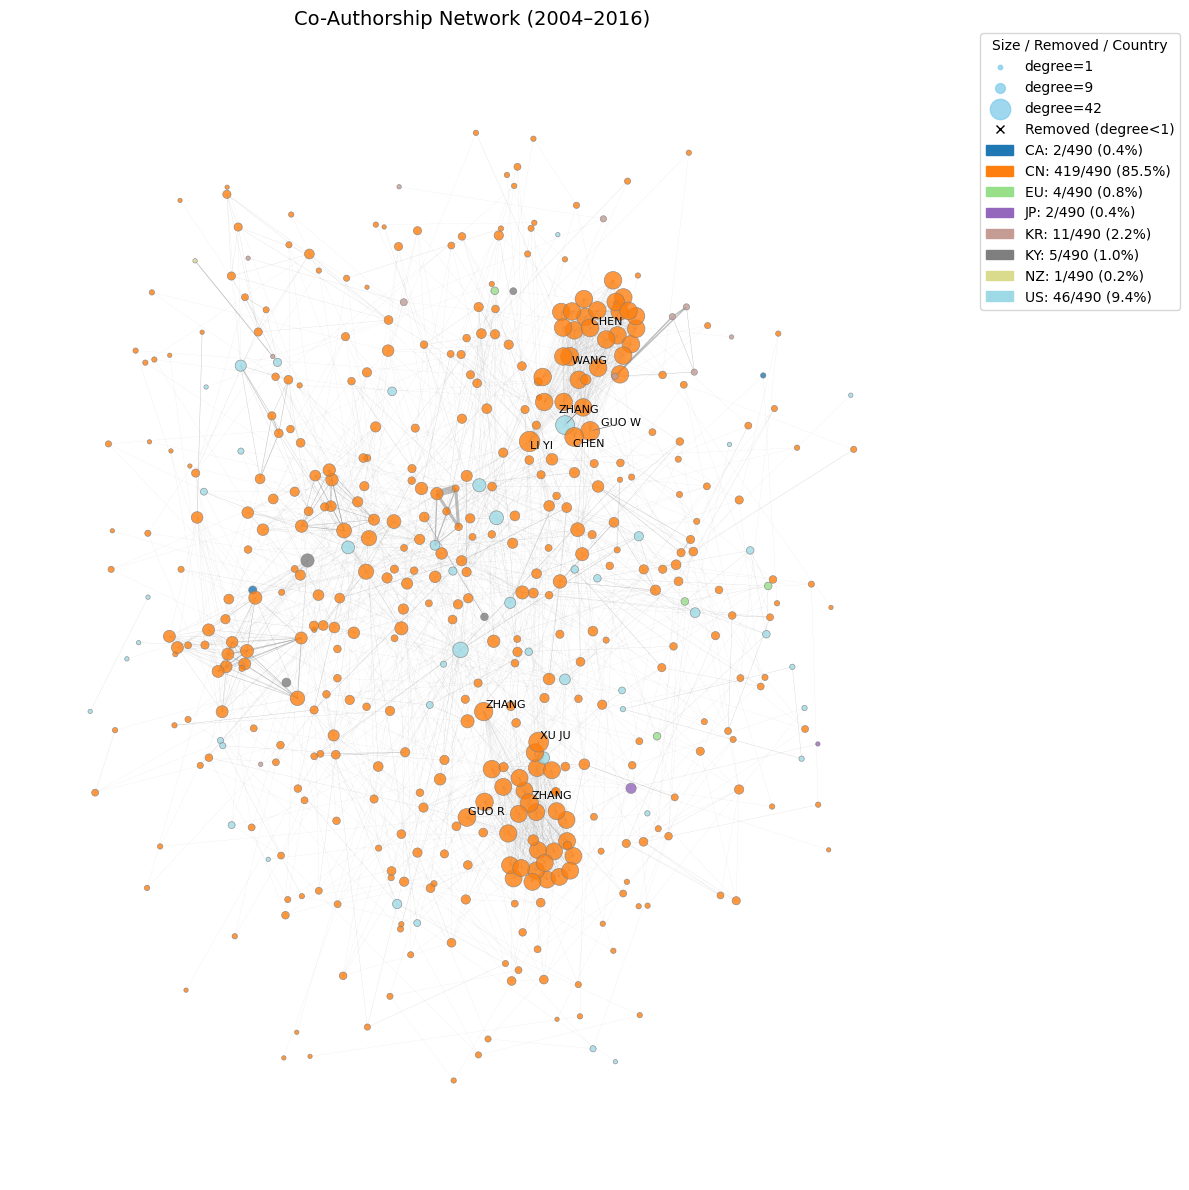

In [32]:
# 셀 8: Co-Authorship Network 시각화 — degree<1 제거, 국가별 색상, 이름 5자 제한, 레이블 겹침 방지, 범례에 비율/크기 반영, 약간 겹침 완화
import matplotlib.pyplot as plt                 # 시각화용 Matplotlib 불러오기
import networkx as nx                            # 그래프 조작용 NetworkX 불러오기
from adjustText import adjust_text               # 레이블 겹침 방지용 adjustText 불러오기
import matplotlib.patches as mpatches            # 범례용 컬러 패치 불러오기
import matplotlib.lines as mlines                # 범례용 선 모양 불러오기

min_degree = 1                                   # 제거 기준 degree 설정 (1 미만 제거)
nodes_kept = [n for n, d in G.degree() if d >= min_degree]  # degree ≥1인 노드만 선택
G2 = G.subgraph(nodes_kept).copy()               # 서브그래프 생성

pos = nx.spring_layout(G2, k=0.2, iterations=20, seed=42)   # 약간 더 벌어지도록 k 증가, 겹침 완화

deg = dict(G2.degree())                          # 노드별 degree dict 생성
nodes, degrees = zip(*deg.items())               # 노드 리스트와 degree 리스트로 분리
node_sizes = [(d + 1) * 5 for d in degrees]      # 노드 크기 설정 (d+1)*5 스케일

weights = [G2[u][v]['weight'] for u, v in G2.edges()]  # 엣지 weight 리스트 생성
widths = [w / max(weights) * 5 for w in weights] if weights else []  # 엣지 굵기 비율 계산

nat_map = {                                      # inventor 이름 → 국가 매핑
    n: df_expl2.loc[df_expl2['inventor'] == n, 'inventor_nat'].iloc[0]
    for n in nodes
}

EU_CODES = {                                     # EU 27개국 코드 집합 (영국 제외)
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}
group_map = {                                    # 그룹핑: GB, EU, 기타
    n: (
        'GB' if nat_map.get(n) == 'GB' else
        'EU' if nat_map.get(n) in EU_CODES else
        nat_map.get(n, 'UN')
    )
    for n in nodes
}

unique_groups = sorted(set(group_map.values()))   # 고유 그룹 리스트 생성
cmap = plt.cm.get_cmap('tab20', len(unique_groups))  # 컬러맵 생성
color_map = {g: cmap(i) for i, g in enumerate(unique_groups)}  # 그룹→색 매핑
node_colors = [color_map[group_map[n]] for n in nodes]  # 노드별 색 리스트

plt.figure(figsize=(12, 12))                     # 그림 사이즈 설정
nx.draw_networkx_edges(G2, pos,
    width=widths, edge_color='gray', alpha=0.5   # 엣지 그리기
)
nx.draw_networkx_nodes(G2, pos,
    nodelist=nodes, node_size=node_sizes,        # 노드 그리기 (크기 적용)
    node_color=node_colors, alpha=0.8,            # 노드 그리기 (색상 적용)
    linewidths=0.5, edgecolors='grey'             # 노드 테두리 설정
)

top10 = sorted(deg, key=deg.get, reverse=True)[:10]  # 상위 10개 노드 선택
labels = {n: n[:5] for n in top10}               # 레이블 5자로 제한
texts = []
for n, lab in labels.items():
    x, y = pos[n]
    texts.append(plt.text(x, y, lab, fontsize=8))  # 레이블 추가
adjust_text(
    texts,
    expand_points=(1.1, 1.1),                     # 레이블 간격 약간만 확장
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5)  # 화살표 스타일
)

total_nodes = len(nodes)                         # 전체 노드 수
avg_deg = int(sum(degrees) / total_nodes)        # 평균 degree 계산
size_handles = [                                 # 노드 크기 범례 핸들 (스케일 일치)
    plt.scatter([], [], s=(d + 1) * 5, color='skyblue', alpha=0.8)
    for d in [min(degrees), avg_deg, max(degrees)]
]
size_labels = [f'degree={d}' for d in [min(degrees), avg_deg, max(degrees)]]  # 크기 레이블

removed_handle = mlines.Line2D(                  # 제거된 노드 정보 핸들
    [], [], linestyle='None', marker='x', color='black',
    label=f'Removed (degree<{min_degree})'
)

group_counts = {g: sum(1 for n in nodes if group_map[n] == g) for g in unique_groups}  # 그룹별 count
group_handles = [                               # 그룹별 색상 범례 핸들
    mpatches.Patch(
        color=color_map[g],
        label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g]/total_nodes:.1%})"
    )
    for g in unique_groups
]

all_handles = size_handles + [removed_handle] + group_handles  # 모든 핸들 합치기
all_labels = size_labels + [removed_handle.get_label()] + [h.get_label() for h in group_handles]
plt.legend(
    all_handles, all_labels,
    title='Size / Removed / Country',             # 범례 제목
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0  # 범례 위치
)

plt.axis('off')                                   # 축 숨기기
plt.title(f'Co-Authorship Network ({min(year_sel)}–{max(year_sel)})', fontsize=14)  # 제목 설정
plt.tight_layout()                                # 레이아웃 조정
plt.show()                                        # 그래프 출력


/tmp/ipython-input-33-3418853966.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap          = cm.get_cmap('tab20', len(unique_groups))


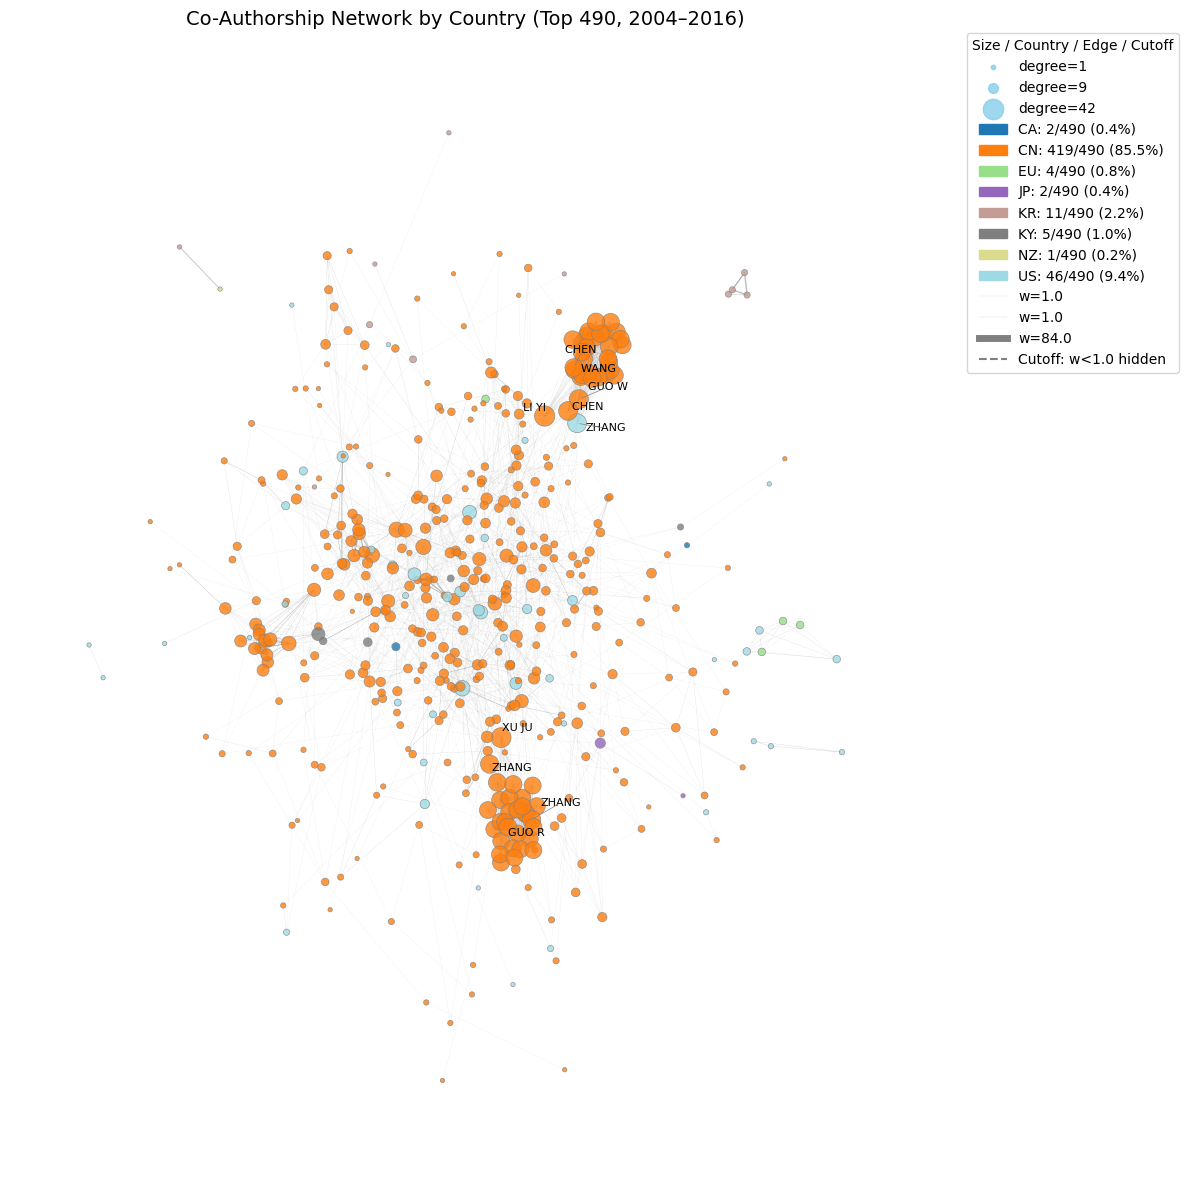

In [33]:
# 셀 9.1: 노드 색상 지정 (영국 제외한 EU는 하나의 그룹으로), 엣지 Cutoff=1.0, 레이블 겹침 방지, legend 및 제목 수정
import matplotlib.pyplot as plt             # 시각화용 Matplotlib
import networkx as nx                       # 그래프 조작용 NetworkX
import matplotlib.cm as cm                  # 컬러맵 모듈
import matplotlib.patches as mpatches       # 범례용 컬러 패치
import matplotlib.lines as mlines           # 범례용 선 모양
from adjustText import adjust_text          # 레이블 겹침 방지용

# 0) nodeㆍedge 준비
min_degree    = 1                                                      # degree 컷오프 기준
nodes_kept    = [n for n, d in G.degree() if d >= min_degree]          # degree ≥1 노드만
G2            = G.subgraph(nodes_kept).copy()                          # 서브그래프
deg           = dict(G2.degree()); nodes, degrees = zip(*deg.items())  # degree dict·리스트
node_sizes    = [(d + 1) * 5 for d in degrees]                         # 노드 크기 스케일

# 1) inventor → country mapping
nat_map = {
    n: df_expl2.loc[df_expl2['inventor']==n, 'inventor_nat'].iloc[0]
    for n in nodes
}

# 2) EU 그룹 정의 및 그룹핑
EU_CODES = {"AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
            "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"}
group_map = {
    n: ('EU' if nat_map[n] in EU_CODES else
        'GB' if nat_map[n]=='GB' else
        nat_map[n] or 'UN')
    for n in nodes
}

# 3) 그룹별 색상 매핑
unique_groups = sorted(set(group_map.values()))
cmap          = cm.get_cmap('tab20', len(unique_groups))
color_map     = {g: cmap(i) for i, g in enumerate(unique_groups)}
node_colors   = [color_map[group_map[n]] for n in nodes]

# 4) 엣지 필터링 (weight ≥1.0)
raw_edges      = list(G.edges(data='weight'))
raw_w          = [w for _,_,w in raw_edges]
threshold      = 1.0
filtered_edges = [(u,v) for u,v,w in raw_edges if w >= threshold]
widths         = [w/max(raw_w)*5 for _,_,w in raw_edges if w >= threshold]

# 5) 레이아웃 소폭 재배치
pos = nx.spring_layout(G, pos=pos, k=0.1, iterations=5, seed=42)

# 6) 그리기
plt.figure(figsize=(12,12))
nx.draw_networkx_edges(G, pos,
                       edgelist=filtered_edges, width=widths,
                       edge_color='gray', alpha=0.5)
nx.draw_networkx_nodes(G, pos,
                       nodelist=nodes, node_size=node_sizes,
                       node_color=node_colors, alpha=0.8,
                       linewidths=0.5, edgecolors='grey')

# 7) 레이블 (Top10, 5자 제한 + 겹침 방지)
top10 = sorted(deg, key=deg.get, reverse=True)[:10]
texts = [plt.text(*pos[n], n[:5], fontsize=8) for n in top10]
adjust_text(texts,
            expand_text=(1.5,1.5), expand_points=(2,2),
            force_text=(0.5,0.5), force_points=(0.2,0.2),
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# 8) 범례 준비
total_nodes  = len(nodes)  # 전체 노드 수
deg_min, deg_avg, deg_max = min(degrees), int(sum(degrees)/total_nodes), max(degrees)
# 8.1) node size legend
size_handles = [plt.scatter([],[], s=(d+1)*5, color='skyblue', alpha=0.8)
                for d in (deg_min, deg_avg, deg_max)]
size_labels  = [f'degree={d}' for d in (deg_min, deg_avg, deg_max)]
# 8.2) country legend
group_counts = {g: sum(1 for n in nodes if group_map[n]==g) for g in unique_groups}
group_handles = [mpatches.Patch(color=color_map[g],
                   label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g]/total_nodes:.1%})")
                 for g in unique_groups]
# 8.3) edge width legend
edge_stats   = [(min(raw_w), min(widths)), (threshold, sum(widths)/len(widths)), (max(raw_w), max(widths))]
edge_handles = [mlines.Line2D([],[], color='gray', lw=scaled, label=f"w={orig:.1f}")
                for orig, scaled in edge_stats]
# 8.4) cutoff legend
cut_handle   = mlines.Line2D([],[], linestyle='--', color='gray',
                             label=f'Cutoff: w<{threshold:.1f} hidden')
# combine and draw legend
all_handles = size_handles + group_handles + edge_handles + [cut_handle]
all_labels  = size_labels + [h.get_label() for h in group_handles] + \
              [h.get_label() for h in edge_handles] + [cut_handle.get_label()]
plt.legend(all_handles, all_labels,
           title='Size / Country / Edge / Cutoff',
           bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.)

# 9) 제목에 Top 노드 수 반영
plt.axis('off')
plt.title(f'Co-Authorship Network by Country (Top {total_nodes}, {min(year_sel)}–{max(year_sel)})', fontsize=14)  # 총 노드 수 포함

plt.tight_layout()
plt.show()


/tmp/ipython-input-34-1797608717.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap          = cm.get_cmap('tab20', len(unique_groups))  # 컬러맵


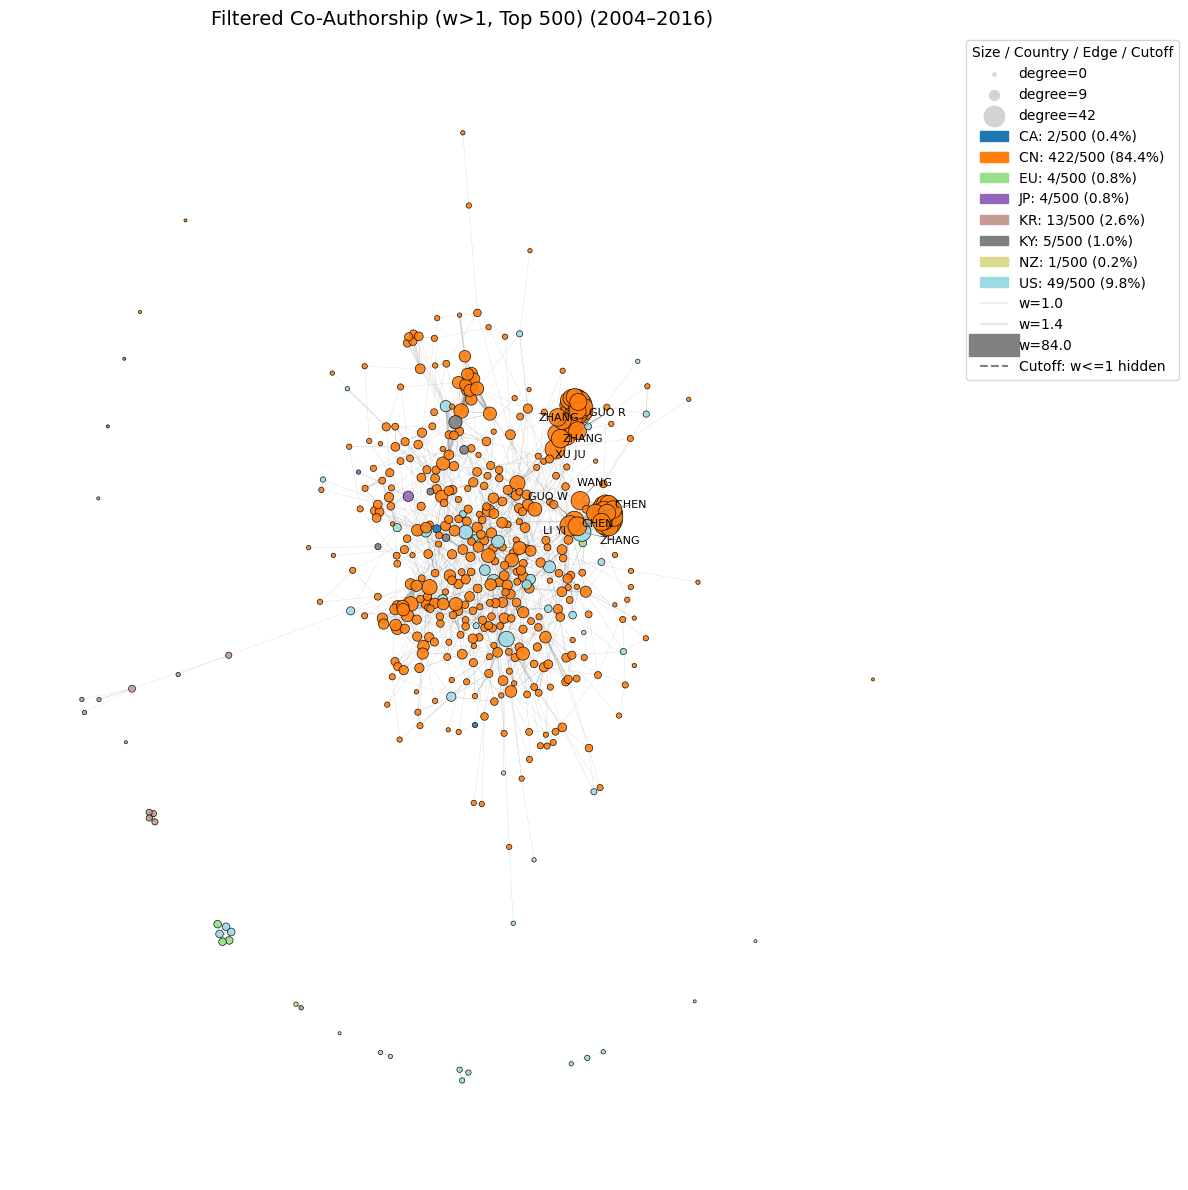

In [34]:
# 셀 9: 국가 기반 클러스터 레이아웃 + 노드 겹침 완화
import numpy as np                              # 수치 계산용 NumPy
import matplotlib.pyplot as plt                 # 시각화용 Matplotlib
import matplotlib.cm as cm                      # 컬러맵
import matplotlib.patches as mpatches           # 범례용 패치
import matplotlib.lines as mlines               # 범례용 선
import networkx as nx                           # 그래프 조작용 NetworkX
from adjustText import adjust_text              # 레이블 겹침 방지용 adjustText

# 0) 엣지 컷오프: weight <1 제거
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 1]  # 컷오프된 엣지 목록
G_filtered     = G.copy()    # 원본 그래프 복사
G_filtered.remove_edges_from(edges_to_remove)  # 컷오프 적용

# 1) top1000 노드 서브그래프
deg_f   = dict(G_filtered.degree())   # degree dict 생성
top_nodes_f = sorted(deg_f, key=deg_f.get, reverse=True)[:1000]                 # 상위 1000 노드
G_sub  = G_filtered.subgraph(top_nodes_f).copy()   # 서브그래프

# 2) 노드→국가 코드 매핑 및 EU 통합
tat = {n: df_expl2.loc[df_expl2['inventor']==n, 'inventor_nat'].iloc[0] for n in G_sub.nodes()}  # 노드→국가
EU_CODES = {"AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR","HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"}
group_map = {n: ('EU' if tat[n] in EU_CODES else tat[n] or 'UN') for n in G_sub.nodes()}  # EU 통합

# 3) 그룹별 중심 원 위에 균등 분포
groups  = sorted(set(group_map.values()))    # 그룹 목록
angles  = np.linspace(0, 2*np.pi, len(groups), endpoint=False)  # 균등한 각도
centers = {g: np.array([np.cos(a), np.sin(a)]) for g, a in zip(groups, angles)}   # 그룹 중심 좌표

# 4) 초기 위치: 그룹 중심 + 랜덤 오프셋
pos_init = {n: centers[group_map[n]] + 0.1 * np.random.randn(2) for n in G_sub.nodes()}  # 초기 pos 설정



# 5) 스프링 레이아웃 적용 (k=3.0, iterations=200으로 노드 간격 넉넉히)
pos = nx.spring_layout(G_sub, pos=pos_init, k=3.0, iterations=200, seed=42)     # repulsion 크게
scale = 1.5                                                                    # 좌표 스케일링 비율
pos = {n: coord * scale for n, coord in pos.items()}


# 6) 스타일 계산
deg_sub     = dict(G_sub.degree())   # degree dict
nodes_sub, degrees_sub = zip(*deg_sub.items())  # 노드, degree 리스트
node_sizes  = [(d + 1) * 5 for d in degrees_sub]   # 노드 크기
weights_sub = [d['weight'] for _,_,d in G_sub.edges(data=True)] # 엣지 weight 리스트
widths_sub  = [max(w * 0.2, 0.1) for w in weights_sub]    # 엣지 굵기

# 7) 색상 매핑
unique_groups = sorted(set(group_map.values()))    # 고유 그룹
cmap          = cm.get_cmap('tab20', len(unique_groups))  # 컬러맵
color_map     = {g: cmap(i) for i, g in enumerate(unique_groups)}   # 그룹→색
node_colors   = [color_map[group_map[n]] for n in G_sub.nodes()]  # 노드별 색

# 8) 시각화: 엣지 → 노드
plt.figure(figsize=(12,12))                                                      # 그림 크기
nx.draw_networkx_edges(G_sub, pos, width=widths_sub, edge_color='gray', alpha=0.4)  # 엣지 그리기
nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, linewidths=0.5, edgecolors='black')  # 노드 그리기

# 9) 라벨링: 상위 10개 노드 5자 + 겹침 방지
top10_sub = sorted(deg_sub, key=deg_sub.get, reverse=True)[:10]  # 상위 10개
texts = [plt.text(*pos[n], n[:5], fontsize=8) for n in top10_sub]  # 5자 라벨
adjust_text(texts, expand_text=(1.5,1.5), expand_points=(2,2), force_text=(0.5,0.5), force_points=(0.2,0.2), arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), lim=1000)  # 레이블 겹침 방지

# 10) 범례 준비
total_nodes  = len(nodes_sub)     # 전체 노드 수
degree_vals  = [min(degrees_sub), int(sum(degrees_sub)/total_nodes), max(degrees_sub)]  # degree 값
size_handles = [plt.scatter([], [], s=(d+1)*5, color='lightgray', label=f'degree={d}') for d in degree_vals]  # 노드 크기 범례
group_counts = {g: sum(1 for n in nodes_sub if group_map[n]==g) for g in unique_groups}  # 그룹별 count
color_handles = [mpatches.Patch(color=color_map[g], label=f"{g}: {group_counts[g]}/{total_nodes} ({group_counts[g]/total_nodes:.1%})") for g in unique_groups]  # 국가 범례
link_vals    = [min(weights_sub), sum(weights_sub)/len(weights_sub), max(weights_sub)]  # weight 값
link_handles = [mlines.Line2D([], [], color='gray', linewidth=max(w*0.2,0.1), label=f"w={w:.1f}") for w in link_vals]  # 엣지 굵기 범례
cut_handle   = mlines.Line2D([], [], linestyle='--', color='gray', label='Cutoff: w<=1 hidden')  # 컷오프 범례
plt.legend(handles=size_handles + color_handles + link_handles + [cut_handle], title='Size / Country / Edge / Cutoff', bbox_to_anchor=(1.05,1), loc='upper left')  # 범례

# 11) 마무리 스타일링
plt.axis('off')   # 축 숨김
plt.title(f'Filtered Co-Authorship (w>1, Top {total_nodes}) ({min(year_sel)}–{max(year_sel)})', fontsize=14)  # 제목
plt.tight_layout()    # 레이아웃 자동 조정
plt.show()      # 그래프 출력


In [35]:
# 셀 10: 연도·PTO_type별 특허 건수 집계, Total 행 추가 및 CSV 저장 (깔끔한 표 출력)
import pandas as pd    # 데이터 처리용 pandas
import os              # 파일 경로 조작용

# 1) 중복 제거
df_type = (
    df_expl2[['year','PTO_type','appl_id']]
      .drop_duplicates()               # (year, PTO_type, appl_id) 중복 제거
)

# 2) 집계
patent_counts_by_type = (
    df_type
      .groupby(['year','PTO_type'])    # 연도·PTO_type별 그룹화
      .size()                          # 특허 건수 카운트
      .reset_index(name='patent_count')
      .pivot(index='year', columns='PTO_type', values='patent_count')
      .fillna(0).astype(int)          # NaN→0, 정수형 변환
)

# 3) Total 행 추가
total_row = patent_counts_by_type.sum(axis=0)  # 열별 합계 계산
total_row.name = 'Total'                       # 행 이름 지정
patent_counts_by_type = pd.concat([
    patent_counts_by_type,
    pd.DataFrame([total_row])
])

# 4) CSV 저장
out_path = os.path.join(base_dir, 'patent_by_PTO_type.csv')
patent_counts_by_type.to_csv(out_path, index=True)  # index(연도+Total) 포함


In [36]:
patent_counts_by_type

PTO_type,CN,EP,JP,KR,US
2000,0,1,0,0,2
2001,0,1,0,0,2
2002,0,0,0,0,20
2003,0,0,0,0,41
2004,0,0,0,0,92
2005,63,66,0,8,207
2006,144,140,2,39,289
2007,170,161,3,39,370
2008,226,232,4,43,365
2009,289,199,3,74,387


In [37]:
# 셀 11: 연도·출원 국가별 집계 (EU 그룹 포함) 및 Total 행 추가
import numpy as np      # 수치 연산용 NumPy
import pandas as pd     # 데이터 처리용 pandas
import os               # 파일 경로 조작용

# 1) country_code & country_group 생성
df_country = df_expl2.copy()

# applicant_nat을 문자열로 변환한 뒤, 앞 2글자 추출 및 대문자화
df_country['country_code'] = (
    df_country['applicant_nat']
      .fillna('')              # NaN → 빈 문자열
      .astype(str)             # 문자열로 변환
      .str[:2]                 # 앞 2글자 추출
      .str.upper()             # 대문자화
)

EU_CODES = {
    "AT","BE","BG","HR","CY","CZ","DK","EE","FI","FR","DE","GR",
    "HU","IE","IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE"
}
df_country['country_group'] = np.where(
    df_country['country_code'].isin(EU_CODES),
    'EU',
    df_country['country_code']
)

# 2) 중복 제거: (year, country_group, appl_id)
df_country = (
    df_country[['year', 'country_group', 'appl_id']]
      .drop_duplicates()
)

# 3) 연도·그룹별 특허 건수 집계 및 pivot
patent_counts_by_country = (
    df_country
      .groupby(['year', 'country_group'])
      .size()
      .reset_index(name='patent_count')
      .pivot(index='year', columns='country_group', values='patent_count')
      .fillna(0)
      .astype(int)
)

# 4) Total 행 추가
total_row = patent_counts_by_country.sum(axis=0)
total_row.name = 'Total'
patent_counts_by_country = pd.concat([
    patent_counts_by_country,
    pd.DataFrame([total_row], index=['Total'])
])


# 5) CSV로 저장
out_path2 = os.path.join(base_dir, 'patent_counts_by_country_by_year.csv')
patent_counts_by_country.to_csv(out_path2, index=True)


In [38]:
patent_counts_by_country

country_group,,,AE,AN,AR,AU,BB,BM,BR,BS,...,TH,TR,TW,UA,US,UY,VG,VN,WS,ZA
2000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,19,0,0,0,0,0
2003,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,28,0,0,0,0,0
2004,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,65,0,0,0,0,0
2005,0,0,0,0,0,3,0,0,0,0,...,0,0,3,0,177,0,0,0,0,0
2006,0,0,1,1,0,1,0,0,0,0,...,0,0,6,0,250,0,0,0,0,0
2007,1,1,0,1,0,2,0,0,1,0,...,0,0,7,0,321,0,1,0,0,0
2008,0,0,0,2,0,7,0,0,0,0,...,0,0,7,0,411,0,1,0,0,0
2009,0,0,0,0,0,6,0,1,0,0,...,0,0,14,0,393,0,1,0,0,1


In [39]:
df_expl2.head(1)

,PTO_id,PTO_type,patent_kind,pub_type_code,title,title_en,abstract,abstract_en,claim_main,claim_main_en,...,orig_ipc_main,orig_ipc_all,wintelips_key,appl_date_parsed,year,country_code,nats_raw,inventor_pre,applicant_nat_pre,applicant
0,US,US,P,B2,"Contextual safety assessment, recommendations,...","문맥 안전 평가, 권장 사항, 프로비저닝 및 모니터링",Method and systems for identifying dangers in ...,액세스 가능한 환경에서 위험을 식별하기 위한 방법과 시스템. 컴퓨터 비전 및 비디오...,1. A method to identify dangers in an accessib...,"1. 접근 가능한 환경에서 위험을 식별하는 방법, 상기 방법은 다음을 포함한다:하나...",...,G06K-009/62,G06K-009/62 | G06N-003/08 | G06F-016/903 | G06...,4.922037e+12,2020-05-29,2020,US,"[ZA, ZA, ZA, ZA]",Maletsabisa Molapo,US,IBM


In [40]:
# df_expl2 중간 확인
display(
    df_expl2[
        ['appl_id','year', 'PTO_type', 'applicant', 'applicant_main_code',  'applicant_nat','country_code','inventor','num_inventors','inventor_nat', 'title', 'abstract', 'claim_main']
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(2)
)


,appl_id,year,PTO_type,applicant,applicant_main_code,applicant_nat,country_code,inventor,num_inventors,inventor_nat,title,abstract,claim_main
0,16/887692,2020,US,IBM,UN000019,US,US,MALETSABISA MOLAPO,4.0,ZA,"Contextual safety assessment, recommendations,...",Method and systems for identifying dangers in ...,1. A method to identify dangers in an accessib...
0,16/887692,2020,US,IBM,UN000019,US,US,CHANE SIMONE MOODLEY,4.0,ZA,"Contextual safety assessment, recommendations,...",Method and systems for identifying dangers in ...,1. A method to identify dangers in an accessib...


In [41]:
# 1) appl_id 기준으로 중복 제거, 첫 번째 행 유지
df_expl2 = df_expl2.drop_duplicates(subset=['appl_id'], keep='first')

# 2) 중간 확인
display(
    df_expl2[
        ['appl_id','year','PTO_type','applicant','applicant_main_code',
         'applicant_nat','country_code','inventor','num_inventors',
         'inventor_nat','title','abstract','claim_main']
    ]
    # .sort_values(by='applicant', ascending=False)
    .head(2)
)


,appl_id,year,PTO_type,applicant,applicant_main_code,applicant_nat,country_code,inventor,num_inventors,inventor_nat,title,abstract,claim_main
0,16/887692,2020,US,IBM,UN000019,US,US,MALETSABISA MOLAPO,4.0,ZA,"Contextual safety assessment, recommendations,...",Method and systems for identifying dangers in ...,1. A method to identify dangers in an accessib...
1,2014-771376,2014,EP,AFRICAN OXYGEN LTD,UN168937,ZA,ZA,DIONISIO ROBERTO MARIA MARCELLO,2.0,ZA,GAS PRESSURE REGULATOR,"A gas pressure regulator (10) is disclosed, co...","A gas pressure regulator (10), comprising: a b..."


In [42]:
df_expl2.shape

(46636, 50)

In [43]:
df_expl2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46636 entries, 0 to 46738
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PTO_id                 46636 non-null  object        
 1   PTO_type               46636 non-null  object        
 2   patent_kind            46636 non-null  object        
 3   pub_type_code          46636 non-null  object        
 4   title                  46636 non-null  object        
 5   title_en               44213 non-null  object        
 6   abstract               46614 non-null  object        
 7   abstract_en            44186 non-null  object        
 8   claim_main             46636 non-null  object        
 9   claim_main_en          44212 non-null  object        
 10  claims_indep           46636 non-null  object        
 11  claims_indep_en        44211 non-null  object        
 12  num_claims             46636 non-null  int64         
 13  appl_i

In [44]:
# !pip uninstall -y torchvision torchaudio pillow 2>/dev/null || true  # 불필요/충돌 가능 패키지 제거

In [45]:
# ==============================================
# PatentSBERTa 기반 특허 텍스트 분류/검색 파이프라인 (경량/고속)
# 목적: 기존 BERT 전체 미세튜닝 대신, ① 임베딩 + 경량 분류기 또는 ② 선택적 LoRA 미세튜닝으로 시간 단축
# ==============================================
# 구성
# 셀 1: 환경 설정 및 패키지 설치
# 셀 2: 라이브러리 로드 및 기본 설정
# 셀 3: 데이터 로딩 (예시: CSV) + 전처리
# 셀 4: Train/Validation 분할
# 셀 5: PatentSBERTa 임베딩 모델 로드
# 셀 6: 임베딩 생성 (캐시 지원)
# 셀 7: 경량 분류기(LogisticRegression) 학습
# 셀 8: 평가 (분류 리포트, 혼동행렬)
# 셀 9: 저장 (임베딩 모델, 분류기, 라벨 인코더)
# 셀 10: 로드 및 추론 함수
# 셀 11: 대량 파일/스트리밍 처리 유틸
# 셀 12 (옵션): LoRA 미세튜닝 (필요 시만 실행)
# 셀 13 (옵션): LoRA 모델 평가 및 저장
# ==============================================

# ─────────────────────────────────────────────
# 셀 12-(1): 패키지 설치 (Colab/최초 1회)
# ─────────────────────────────────────────────
# !pip install -q sentence-transformers scikit-learn faiss-cpu joblib pandas numpy tqdm seaborn
# (옵션 LoRA) !pip install -q peft transf

In [46]:
# 셀 12-(1): 환경 초기화 및 호환 버전 설치

# 0) 충돌 제거
!pip uninstall -y torch torchvision torchaudio fastai pillow 2>/dev/null || true

# 1) 필수 라이브러리 (torch 2.6.0 + cu124 / torchvision 0.21.0 + cu124)
!pip install -U pip
!pip install --index-url https://download.pytorch.org/whl/cu124 \
    torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0

# 2) 나머지 패키지
!pip install -q sentence-transformers>=2.7.0 scikit-learn pandas numpy fastai==2.7.19

# 3) (선택) vision 비활성화 플래그 – transformers 가 vision 서브모듈 로딩 방지
import os
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"
os.environ["DISABLE_TRANSFORMERS_AV"] = "1"

# 4) 설치 확인
import torch
import torchvision
import PIL

print("Torch        :", torch.__version__)
print("Torchvision  :", torchvision.__version__)
print("Pillow       :", PIL.__version__)
try:
    import fastai
    print("FastAI       :", fastai.__version__)
except:
    print("FastAI not installed")


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: pillow 11.2.1
Uninstalling pillow-11.2.1:
  Successfully uninstalled pillow-11.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 134.5 MB/s eta 0:00:00
     ━━━

In [47]:
# 셀 12-(2): 기본 import 및 전역 설정
import os, re                                                        # OS, 정규식
import numpy as np                                                   # 수치 연산
import pandas as pd                                                  # 데이터프레임
from sklearn.model_selection import train_test_split                 # 데이터 분할
TEXT_COLS = ["title","abstract","claim_main"]                        # 결합할 텍스트 컬럼 지정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"              # GPU/A100 사용 여부
print("Device:", DEVICE)                                             # 디바이스 출력


Device: cpu


In [48]:
# df_expl2를 복사하여 df_expl3 생성
# 원본 보존용 복제본 생성
df_expl3 = df_expl2.copy()


In [49]:
# ==============================================
# 셀 12-(3): fulltext 생성 및 Seed LLM 라벨 생성 (확장 + 한국어 상세 주석 강화)
# ==============================================
# 목적:
#  - 특허/문헌 텍스트에서 LLM/Transformer 관련 기술·모델·방법론 언급 여부를 1/0 라벨로 부여
#  - 다국어(한/중/일) 및 최신 한국/중국/글로벌 모델명 포함
#  - 구조적(카테고리별) 키워드 관리 → 유지보수 용이
#  - False Positive(일반 단어와 충돌) 최소화를 위한 후처리 옵션 제공

# 전제:
#  - TEXT_COLS: 결합할 텍스트 컬럼 리스트 (이미 상위 셀에서 정의되어 있다고 가정)
#  - df_expl3: 라벨을 부여할 DataFrame
#  - fulltext 컬럼이 없으면 생성, 있으면 재사용

def combine_text(r):
    """
    행(row)의 TEXT_COLS 내 텍스트를 결합하여 fulltext 문자열 생성.
    - None/빈 문자열/비문자 타입(예: float, int)은 제외
    - 줄바꿈 전/후 공백 제거
    - 구분은 " \n " (줄 단위로 결합) → 추후 문장 분해/패턴 매칭 시 가독성 유지
    """
    return " \n ".join([
        str(r[c]).strip()
        for c in TEXT_COLS
        if c in r and isinstance(r[c], str) and r[c].strip()
    ])

# fulltext 컬럼이 없을 경우에만 생성 (이미 전처리에서 만든 경우 중복 연산 회피)
if "fulltext" not in df_expl3.columns:
    df_expl3["fulltext"] = df_expl3.apply(combine_text, axis=1)

import re

# ==============================================
# (A) 카테고리별 키워드 정의
#  - 각 리스트는 해당 주제/범주에 속하는 정규식 패턴 문자열
#  - 패턴 작성 원칙:
#     * 소문자/대문자 구분 제거: re.IGNORECASE 사용
#     * 변형/숫자/Parameter size(7B, 13B 등)는 (?:[-\s]?[0-9]+[bBkK]?)? 로 포괄
#     * 하이픈/공백 모두 허용: [-\s]? 또는 [-\s]?복합 사용
#     * 과매칭 위험(일반 단어) → 후처리(filter_false_positives)에서 문맥 검사
#  - 필요 시 특정 카테고리를 제외하면 즉시 정규식 범위 축소 가능
# ==============================================

# -------- core_models : 모델명(브랜드/패밀리) --------
# --------------------------------------------------------
# core_models : 전세계 + 중국 + 한국 LLM 고유명사/브랜드/대표 패밀리
# - 목적: 텍스트 안에 특정 모델 언급(특허/논문/기사) 탐지
# - 포함: 상용(Claude, Gemini), 오픈소스(LLaMA, Mistral), 연구(BLOOM, Chinchilla), 중국(Qwen, DeepSeek, KIMI, ChatGLM 등), 한국(HyperCLOVA, EXAONE, SOLAR, Midm 등)
# - 주의: 일반 단어와 충돌 가능 (claude, ernie, solar 등) → 후처리 필터 권장
# --------------------------------------------------------
# 주의: 'claude', 'ernie', 'solar' 는 일반 단어/인명과 충돌 가능
core_models = [
    # 글로벌 / 오픈 / 상용
    r'large language model', r'LLM', r'neural language model(?:s)?',
    r'foundation model', r'chatgpt', r'gpt[-\s]?[0-9]+(?:\.[0-9])?',
    r'bert(?:-\w+)?', r'roberta', r't5', r'longt5', r'xlnet', r'albert', r'distilbert',
    r'ul2', r'falcon', r'mistral', r'mixtral', r'gemma', r'orca',
    r'phi[-\s]?[0-9]+', r'openelm', r'vicuna', r'guanaco',
    # LLaMA 계열
    r'llama(?:[-\s]?(?:[0-9]+[bBkK]?|2|3))?', r'codellama', r'openllama',
    # 주요 상용/대형
    r'claude(?:[-\s]?[0-9]+)?',          # FP 가능 (인명) → 후처리
    r'gemini(?:[-\s]?(?:pro|ultra|flash)?)?',
    r'palm[-\s]?2', r'palm2',
    r'opt(?:[-\s]?[0-9]+[bBkK]?)?', r'gopher', r'chinchilla',
    r'megatron[-\s]?turing(?:[-\s]?nlg)?', r'mt[-\s]?nlg', r'megatron',
    r'gpt[-\s]?neox(?:[-\s]?[0-9]+[bBkK]?)?', r'gpt[-\s]?neo(?:[-\s]?[0-9]+[bBkK]?)?',
    r'gpt[-\s]?j(?:[-\s]?[0-9]+[bBkK]?)?',
    # 커뮤니티 / 오픈
    r'bloomz?(?:[-\s]?[0-9]+[bBkK]?)?', r'jurassic(?:[-\s]?(?:1|2|jr))?',
    r'mpt(?:[-\s]?[0-9]+[bBkK]?)?', r'pythia(?:[-\s]?[0-9]+[bBkK]?)?',
    r'dolly(?:[-\s]?[0-9]+[bBkK]?)?', r'stablelm(?:[-\s]?[0-9]+[bBkK]?)?',
    r'rwkv(?:[-\s]?[0-9]+[bBkK]?)?', r'starcoder(?:[-\s]?[0-9]+[bBkK]?)?',
    r'codegen(?:[-\s]?[0-9]+[bBkK]?)?', r'codet5(?:[-\s]?[0-9]+[bBkK]?)?',
    r'wizardlm(?:[-\s]?[0-9]+[bBkK]?)?', r'wizardcoder(?:[-\s]?[0-9]+[bBkK]?)?',
    r'zephyr(?:[-\s]?[0-9]+[bBkK]?)?', r'phi(?:[-\s]?[0-9]+[bBkK]?)?',
    r'medalpaca', r'finet5', r'biogpt', r'chemberta',
    r'CodeBERT', r'BioBERT', r'clinicalbert',
    # 중국
    r'ernie', r'wenxin', r'ernie bot', r'qwen(?:[-\s]?[0-9]+[bBkK]?)?',
    r'deepseek(?:[-\s]?[0-9]+[bBkK]?)?', r'yi(?:[-\s]?[0-9]+[bBkK]?)?',
    r'baichuan(?:[-\s]?[0-9]+[bBkK]?)?', r'chatglm(?:[-\s]?[0-9]+)?',
    r'internlm(?:[-\s]?[0-9]+[bBkK]?)?', r'pangu(?:[-\s]?[0-9]+[bBkK]?)?',
    r'sparkdesk', r'sensechat', r'kimi(?:[-\s]?chat)?', r'abab(?:[-\s]?[\w]+)?',
    r'ziya', r'm6', r'aquila(?:[-\s]?[\w]+)?',
    # 한국
    r'hyperc[lL]ova(?:[-\s]?(?:x|2|[0-9]+[bBkK]?))?', r'kogpt(?:[-\s]?[0-9]+[bBkK]?)?',
    r'polyglot(?:[-\s]?ko)?(?:[-\s]?[0-9]+[bBkK]?)?', r'koalpaca',
    r'clovax', r'클로바엑스', r'solar(?:[-\s]?[0-9]+[bBkK]?)?', r'솔라',
    r'exaone(?:[-\s]?(?:2|2\.0|[0-9]+[bBkK]?))?', r'엑사원',
    r'kullm(?:[-\s]?[0-9]+[bBkK]?)?', r'kovicuna', r'코비쿠나',
    r'kolama', r'kollama', r'korwkv', r'kollm', r'kocoder',
    r'korean[-\s]?stablelm', r'korealm', r'하이퍼클로바', r'한국어\s?LLM'
]

# -------- 아키텍처 변형 / 구조적 확장 --------
# model_variants_arch : 아키텍처 확장/변형 (희소, 확장, 특수구조)
# - 목적: 구조적 혁신(Perceiver, Mixture-of-Experts, State Space 등) 탐지
# - FP 낮음 (대부분 전문 용어)
# --------------------------------------------------------
model_variants_arch = [
    r'transformer[-\s]?(?:based|encoder|decoder)?', r'encoder[-\s]?decoder',
    r'sequence-to-sequence', r'esm(?:[-\s]?[0-9]+)?',
    r'mixture[-\s]?of[-\s]?experts', r'MoE', r'sparsely[-\s]?gated mixture[-\s]?of[-\s]?experts',
    r'Switch[-\s]?Transformer', r'GShard', r'stacked mixture[-\s]?of[-\s]?experts',
    r'sparse transformer', r'perceiver(?:[-\s]?IO)?', r'transformer[-\s]?xl',
    r'hierarchical transformer', r'dynamic convolution', r'conformer',
    r'hypernetwork', r'graph transformer', r'state space model', r'Mamba'
]

# -------- 어텐션 / 포지셔널 / 컨텍스트 --------
# attention_positional : 어텐션 및 위치/컨텍스트 처리 기법
# - 목적: 효율/성능/긴문맥 관련 메커니즘 추출
# - 활용: 모델 성능·추론최적화 연구 태깅
# --------------------------------------------------------
attention_positional = [
    r'self[-\s]?attention', r'multi[-\s]?head attention', r'attention mechanism',
    r'sparse attention', r'global attention', r'local attention', r'axial attention',
    r'linear attention', r'flash attention', r'scaled dot[-\s]?product attention',
    r'cross[-\s]?attention', r'memory attention', r'rotary positional embedding', r'RoPE',
    r'ALiBi', r'relative positional encoding', r'absolute positional encoding',
    r'sinusoidal positional encoding', r'position[-\s]?wise feed[-\s]?forward',
    r'kv[-\s]?cache', r'windowed attention', r'blockwise attention'
]

# -------- 파라미터 효율 / PEFT --------
# parameter_efficiency : 파라미터 효율 미세조정(PEFT) 기법
# - 목적: 비용 절감·경량화 기법 탐지
# - 분석 포인트: 모델 재사용성, 적은 데이터 적응
# --------------------------------------------------------
parameter_efficiency = [
    r'parameter[-\s]?efficient fine[-\s]?tuning', r'PEFT', r'LoRA', r'QLoRA',
    r'adapter(?:s)?', r'adapter[-\s]?layer', r'prefix[-\s]?tuning', r'prompt[-\s]?tuning',
    r'soft prompt(?:ing)?', r'p[-\s]?tuning', r'bitfit', r'low[-\s]?rank adaptation',
    r'sparse fine[-\s]?tuning', r'lightweight fine[-\s]?tuning', r'hypernetwork adaptation',
    r'lora[-\s]?merged', r'training head', r'partial fine[-\s]?tuning'
]

# -------- 학습 패러다임 / 정렬 / 목적 --------
# training_paradigms : 학습 목적·전략·튜닝 프로세스
# - 목적: 사전학습 목적 / 튜닝 종류 / 정렬 학습 방식 태깅
# - DPO, RLAIF 등 최신 preference 최적화 포함
# --------------------------------------------------------
training_paradigms = [
    r'pretraining', r'pre[-\s]?training', r'masked language model(?:s)?',
    r'autoregressive model(?:s)?', r'denoising objective', r'causal language modeling',
    r'span corruption', r'instruction[-\s]?tuning', r'supervised fine[-\s]?tuning',
    r'SFT', r'alignment tuning', r'contrastive learning', r'multi[-\s]?task learning',
    r'domain adaptation', r'curriculum learning', r'continual learning',
    r'reinforcement learning from human feedback', r'RLHF',
    r'RLAIF', r'DPO', r'direct preference optimization',
    r'offline reinforcement learning', r'self[-\s]?distillation', r'knowledge distillation'
]

# -------- 프롬프트 / 추론 / Reasoning --------
# prompting_inference : 프롬프트 설계·추론 강화·Reasoning 전략
# - 목적: CoT, ReAct, Tree-of-Thought 등 추론 향상 패턴 탐지
# - 활용: reasoning 성능 비교, 기법 빈도 분석
# --------------------------------------------------------
prompting_inference = [
    r'prompt[-\s]?engineering', r'prompt[-\s]?tuning', r'prompt design',
    r'few[-\s]?shot (?:learning|inference)', r'one[-\s]?shot learning', r'zero[-\s]?shot learning',
    r'chain[-\s]?of[-\s]?thought', r'CoT', r'self[-\s]?consistency',
    r'tree[-\s]?of[-\s]?thought', r'graph[-\s]?of[-\s]?thought', r'deliberate reasoning',
    r'scratchpad', r'react framework', r'REACT', r'function calling', r'tool use',
    r'planning prompting', r'reflection prompting', r'progressive hinting',
    r'role prompting', r'instruction following', r'reasoning step'
]

# -------- 검색 / 메모리 / RAG --------
# retrieval_memory : 검색·외부지식 결합·메모리 확장
# - 목적: RAG 기반 파이프라인/컨텍스트 관리 전략 탐지
# - 활용: LLM+지식그래프/DB 통합 연구 분류
# --------------------------------------------------------
retrieval_memory = [
    r'retrieval[-\s]?augmented generation', r'RAG', r'knowledge grounding',
    r'vector store', r'faiss index', r'elastic vector search', r'semantic cache',
    r'external memory', r'memory transformer', r'episodic memory', r'kNN[-\s]?LM',
    r'retrieval head', r'hybrid retrieval', r'context window extension', r'chunking strategy',
    r'context compression', r'document augmentation', r'oracle retrieval'
]

# -------- 정렬 / 안전 / 윤리 --------
# alignment_safety : 가치정렬·안전성·오용 방지
# - 목적: RLHF/안전필터/레드팀 등 정책·제어 관련 용어 탐지
# - 활용: RAI 전략 비교, 규제·거버넌스 근거 도출
# --------------------------------------------------------
alignment_safety = [
    r'value alignment', r'model alignment', r'safety alignment', r'alignment tax',
    r'harmlessness', r'hallucination reduction', r'mitigat(?:e|ion) bias',
    r'red teaming', r'safety filter', r'content moderation', r'toxicity detection',
    r'safety policy', r'responsible AI', r'harm minimization', r'refusal policy',
    r'ethical guardrail', r'over[-\s]?refusal', r'jailbreak defense'
]

# -------- 다국어 / 교차언어 --------
# multilingual_crosslingual : 다국어/교차언어 적응
# - 목적: 번역·교차 전이·언어 내재화 전략 탐지
# - 활용: 다언어 성능/데이터 편향 분석
# --------------------------------------------------------
multilingual_crosslingual = [
    r'multilingual model', r'cross[-\s]?lingual transfer', r'code[-\s]?switching',
    r'language adaptation', r'multilingual embedding', r'cross[-\s]?lingual alignment',
    r'bilingual lexicon induction', r'machine translation'
]

# -------- 태스크 / 응용 --------
# tasks_applications : 적용 태스크/도메인 활용
# - 목적: LLM 활용 영역 분포(요약/QA/코드 등) 측정
# - 참고: 과매칭 우려 낮으나 범용 단어 등장 가능 (필요 시 필터)
# --------------------------------------------------------
tasks_applications = [
    r'text generation', r'text summarization', r'machine translation',
    r'question answering', r'natural language understanding',
    r'language understanding', r'language generation', r'semantic parsing',
    r'dialogue generation', r'conversation agent', r'conversational AI',
    r'information extraction', r'entity recognition', r'slot filling',
    r'sentiment analysis', r'code generation', r'program synthesis'
]

# -------- 최적화 / 효율 / 병렬 --------
# optimization_efficiency : 학습/추론 효율·병렬·압축
# - 목적: 비용 절감/성능-자원 최적화 기술 태깅
# - 활용: 인프라 전략·운영 효율 연구
# --------------------------------------------------------
optimization_efficiency = [
    r'gradient checkpointing', r'mixed precision training', r'fp16', r'bf16',
    r'quantization', r'8[-\s]?bit quantization', r'4[-\s]?bit quantization',
    r'int8 inference', r'weight pruning', r'sparsification', r'kv cache reuse',
    r'pipeline parallel(?:ism)?', r'tensor parallel(?:ism)?', r'data parallel(?:ism)?',
    r'megatron', r'deepseed', r'zero redundancy optimizer', r'ZeRO',
    r'activation offloading', r'flash inference', r'graph optimisation',
    r'operator fusion', r'compilation caching'
]

# -------- 표현 / 임베딩 / 토크나이징 --------
# representation_embeddings : 임베딩·토크나이징·표현학습
# - 목적: 입력 전처리/표현 품질 개선 기법 탐지
# - 활용: 서브워드 전략·문맥 임베딩 진화 분석
# --------------------------------------------------------
representation_embeddings = [
    r'contextual (?:embedding|representation)', r'word embedding',
    r'vector embedding', r'sentence embedding', r'document embedding',
    r'tokenization', r'subword tokenization', r'byte[-\s]?pair encoding', r'BPE',
    r'wordpiece', r'unigram language model tokenization', r'sentencepiece',
    r'morpheme segmentation', r'multivector embedding'
]

# -------- 평가 / 벤치마크 / 지표 --------
# evaluation_benchmark : 평가/벤치마크/지표
# - 목적: 모델 성능 비교에 사용되는 데이터셋·지표 탐지
# - FP 가능: 'perplexity' 일반적 언급, 필요시 제외
# --------------------------------------------------------
evaluation_benchmark = [
    r'perplexity', r'benchmark suite', r'few[-\s]?shot benchmark', r'mmlu',
    r'hellaswag', r'arc[-\s]?challenge', r'BIG[-\s]?bench', r'winogrande',
    r'truthfulqa', r'bbh', r'codeeval', r'leaderboard evaluation', r'human eval'
]

# -------- 디코딩 / 출력 제어 --------
# misc_components : 디코딩·출력 제어·추론 설정
# - 목적: 생성 품질/다양성/안정성 조정 기법 탐지
# --------------------------------------------------------
misc_components = [
    r'decoder[-\s]?only model', r'causal decoder', r'beam search',
    r'top[-\s]?k sampling', r'top[-\s]?p sampling', r'nucleus sampling',
    r'temperature scaling', r'repetition penalty', r'length penalty',
    r'stop sequence', r'streaming generation', r'context window',
    r'sliding window decoding'
]

# -------- 비영문(한·중·일) 핵심 용어 --------
# local_lang_terms : 다국어(한/중/일) LLM 핵심 용어
# - 목적: 비영문 코퍼스에서 LLM 관련 문맥 탐지
# - 주의: 일부 일반적(언어 모델) → 과매칭 시 제거 고려
# --------------------------------------------------------
#  * '언어 모델' 과매칭 많으면 제거 고려
local_lang_terms = [
    # 한국어
    r'대규모 언어 모델', r'언어 모델', r'사전 학습 언어 모델',
    r'프롬프트 엔지니어링', r'프롬프트 튜닝', r'체인 오브 생각',
    # 중국어
    r'大规模语言模型', r'语言模型', r'预训练语言模型',
    r'提示工程', r'提示调优', r'链式思维',
    # 일본어
    r'大規模言語モデル', r'言語モデル', r'事前学習言語モデル',
    r'プロンプトエンジニアリング', r'プロンプトチューニング', r'思考の連鎖'
]

# (B) 카테고리 사전
LLM_KEYWORD_CATEGORIES = {
    "core_models": core_models,
    "model_variants_arch": model_variants_arch,
    "attention_positional": attention_positional,
    "parameter_efficiency": parameter_efficiency,
    "training_paradigms": training_paradigms,
    "prompting_inference": prompting_inference,
    "retrieval_memory": retrieval_memory,
    "alignment_safety": alignment_safety,
    "multilingual_crosslingual": multilingual_crosslingual,
    "tasks_applications": tasks_applications,
    "optimization_efficiency": optimization_efficiency,
    "representation_embeddings": representation_embeddings,
    "evaluation_benchmark": evaluation_benchmark,
    "misc_components": misc_components,
    "local_lang_terms": local_lang_terms
}

# (C) 전체 패턴 병합
#  - set으로 중복 제거 → 길이 내림차순 정렬(긴 패턴 우선 매칭 → 과도한 부분매칭 감소)
all_keywords = set()
for lst in LLM_KEYWORD_CATEGORIES.values():
    all_keywords.update(lst)

sorted_keywords = sorted(all_keywords, key=len, reverse=True)

# \b 경계: 영문 토큰 기준. 한중일 문자열에는 크게 문제 없지만
#  - 더 정밀 필요 시 (?<!\w) ... (?!\w) 사용 고려
LLM_PATTERN = re.compile(r'\b(' + "|".join(sorted_keywords) + r')\b', re.IGNORECASE)

# (D) False Positive 후처리
def filter_false_positives(matches, text, window=50):
    """
    FP 최소화 룰 기반 필터:
    - claude: Anthropic 모델 언급 아니면 제거
    - ernie : 'bot','wenxin','baidu','llm' 인접 없으면 제거
    - solar : 일반 'solar panel' 혼동 방지 위해 'llm','model','upstage' 체크
    window: 양 옆 문맥 길이(문자 수)
    """
    lt = text.lower()
    filtered = []
    for m in matches:
        token = m.lower()
        idx = lt.find(token)
        ctx = lt[max(0, idx - window): idx + len(token) + window]
        keep = True
        if token.startswith('claude') and not any(k in ctx for k in ['anthropic', 'model', 'ai', 'llm']):
            keep = False
        if token == 'ernie' and not any(k in ctx for k in ['bot', 'wenxin', 'baidu', 'llm']):
            keep = False
        if token.startswith('solar') and not any(k in ctx for k in ['llm', 'model', 'upstage']):
            keep = False
        if keep:
            filtered.append(m)
    return filtered

# (E) Seed 라벨 함수
def seed_label(txt):
    """
    개별 문서/텍스트에 대해:
      1) 문자열 아니면 0
      2) 정규식 매칭 → 후보 목록
      3) FP 후처리 적용
      4) 남은 매칭 존재 시 1, 없으면 0
    고급 확장:
      - 매칭 토큰/카테고리 리스트를 별도 컬럼(df_expl3['llm_hits'])로 저장 가능
      - 카테고리 빈도 분석 추가 가능
    """
    if not isinstance(txt, str):
        return 0
    raw_matches = re.findall(LLM_PATTERN, txt)
    if not raw_matches:
        return 0
    filtered = filter_false_positives(raw_matches, txt)
    return 1 if filtered else 0

# (F) 라벨 생성
df_expl3["seed_llm_label"] = df_expl3["fulltext"].apply(seed_label)
df_expl3["final_label"] = df_expl3["seed_llm_label"]

# (G) 라벨 분포 출력 (품질 점검: 비율이 너무 높거나 낮으면 패턴/FP 필터 조정)
print("Seed label distribution:\n", df_expl3["final_label"].value_counts())




Seed label distribution:
 final_label
0    39025
1     7611
Name: count, dtype: int64


In [50]:
df_expl3["final_label"].value_counts()

,count
final_label,
0,39025
1,7611


In [51]:
# (선택) 품질 신속 점검 예:
print("라벨 비율(%) =", round(df_expl3['final_label'].mean()*100, 2))
df_expl3.loc[df_expl3['final_label']==1, ['appl_id','fulltext']].head(3)

라벨 비율(%) = 16.32


,appl_id,fulltext
5,17/160103,"Encoder, system and method for metaphor detect..."
7,14/943703,Automatically assessing question answering sys...
37,16/230338,Generic virtual personal assistant platform \n...


In [52]:
df_expl3.shape

(46636, 53)

In [53]:
display(df_expl3.head(3))

,PTO_id,PTO_type,patent_kind,pub_type_code,title,title_en,abstract,abstract_en,claim_main,claim_main_en,...,appl_date_parsed,year,country_code,nats_raw,inventor_pre,applicant_nat_pre,applicant,fulltext,seed_llm_label,final_label
0,US,US,P,B2,"Contextual safety assessment, recommendations,...","문맥 안전 평가, 권장 사항, 프로비저닝 및 모니터링",Method and systems for identifying dangers in ...,액세스 가능한 환경에서 위험을 식별하기 위한 방법과 시스템. 컴퓨터 비전 및 비디오...,1. A method to identify dangers in an accessib...,"1. 접근 가능한 환경에서 위험을 식별하는 방법, 상기 방법은 다음을 포함한다:하나...",...,2020-05-29,2020,US,"[ZA, ZA, ZA, ZA]",Maletsabisa Molapo,US,IBM,"Contextual safety assessment, recommendations,...",0,0
1,EP,EP,P,B1,GAS PRESSURE REGULATOR,가스 압력 조절기,"A gas pressure regulator (10) is disclosed, co...",가스 유입 스템 (14)이 장착된 본체 (12)를 포함하는 가스 압력 조절기 (10...,"A gas pressure regulator (10), comprising: a b...",가스 압력 조절기 (10) 포함: 가스 유입 스템 (14)이 장착된 본체 (12) ...,...,2014-07-18,2014,ZA,"[ZA, ZA]","DIONISIO, Roberto, Maria, Marcello",ZA,AFRICAN OXYGEN LTD,GAS PRESSURE REGULATOR \n A gas pressure regul...,0,0
2,US,US,P,B2,Gas pressure regulator,가스 압력 조절기,"A gas pressure regulator (10) is disclosed, co...",가스 유입 스템 (14)이 장착된 본체 (12)를 포함하는 가스 압력 조절기 (10...,"1. A gas pressure regulator, comprising: a bod...","1. 가스 압력 조절기, 다음을 포함한다:제 1 압력에서 가스 소스로부터 가스를 공...",...,2014-07-18,2014,ZA,"[ZA, ZA]",Roberto Maria Marcello Dionisio,ZA,AFRICAN OXYGEN LTD,Gas pressure regulator \n A gas pressure regul...,0,0


In [54]:
# 셀 12-(4): Train / Validation 데이터 분할 (층화)
train_df, valid_df = train_test_split(
    df_expl3[["fulltext","final_label"]].dropna(),   # 결측 제거
    test_size=0.1,
    random_state=42,
    stratify=df_expl3["final_label"]
)
print("Train size:", len(train_df), "Valid size:", len(valid_df)) # 데이터 크기 출력


Train size: 41972 Valid size: 4664


In [55]:
# 셀 12-(5): PatentSBERTa 모델 로드 (임베딩 추출용)
from sentence_transformers import SentenceTransformer  # SentenceTransformer import
MODEL_NAME = "AI-Growth-Lab/PatentSBERTa"   # PatentSBERTa 모델명
sbert = SentenceTransformer(MODEL_NAME, device=DEVICE)  # 모델 로드
print("Embedding dim:", sbert.get_sentence_embedding_dimension()) # 임베딩 차원 출력


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding dim: 768


In [56]:
# 셀 12-(6): 임베딩 추출 함수 정의 및 Train/Valid 임베딩 생성
def encode_texts(texts, batch_size=64, normalize=True): # 텍스트 리스트 → 임베딩
    return sbert.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=normalize
    )
train_texts = train_df["fulltext"].tolist()  # 학습 텍스트 리스트
valid_texts = valid_df["fulltext"].tolist()   # 검증 텍스트 리스트
X_train = encode_texts(train_texts)   # 학습 임베딩
X_valid = encode_texts(valid_texts)  # 검증 임베딩
y_train = train_df["final_label"].values     # 학습 라벨
y_valid = valid_df["final_label"].values     # 검증 라벨
print("Train embedding shape:", X_train.shape)  # 임베딩 크기 출력
print("Valid embedding shape:", X_valid.shape)  # 임베딩 크기 출력


Batches:   0%|          | 0/656 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# 셀 12-(7): 로지스틱 회귀 분류기 학습 (빠른 베이스라인)
from sklearn.linear_model import LogisticRegression  # 로지스틱 회귀
from sklearn.metrics import accuracy_score, f1_score, classification_report  # 평가 함수

log_clf = LogisticRegression(
    max_iter=300,     # 최대 반복
    class_weight="balanced",  # 클래스 불균형 자동 가중
    n_jobs=-1,    # 병렬 처리
    solver="lbfgs"    # 안정적 최적화
)
log_clf.fit(X_train, y_train)     # 모델 학습
valid_pred = log_clf.predict(X_valid)   # 검증 예측
valid_proba = log_clf.predict_proba(X_valid)[:,1]    # LLM 확률
print("LogReg Accuracy:", accuracy_score(y_valid, valid_pred))  # 정확도 출력
print("LogReg F1(macro):", f1_score(y_valid, valid_pred, average="macro"))# F1 출력
print(classification_report(y_valid, valid_pred)) # 상세 리포트


In [ ]:
# 셀 12-(8): (선택) 간단 MLP 분류기 (임베딩 고정) - 필요 없으면 건너뛰기
USE_MLP = True   # MLP 사용 여부 스위치
if USE_MLP:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    torch.manual_seed(42)
    in_dim = X_train.shape[1]

    class MLPClassifier(nn.Module): # 간단 2층 MLP
        def __init__(self, in_dim, hidden=256, drop=0.2):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Dropout(drop),
                nn.Linear(hidden, 2)
            )
        def forward(self, x):
            return self.net(x)

    mlp = MLPClassifier(in_dim).to(DEVICE)   # 모델 인스턴스
    Xtr_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE) # 학습 임베딩 텐서
    ytr_t = torch.tensor(y_train, dtype=torch.long).to(DEVICE) # 학습 라벨 텐서
    Xva_t = torch.tensor(X_valid, dtype=torch.float32).to(DEVICE) # 검증 임베딩 텐서
    yva_t = torch.tensor(y_valid, dtype=torch.long).to(DEVICE)# 검증 라벨 텐서

    pos = (y_train==1).sum(); neg = (y_train==0).sum() # 클래스 수 계산
    w_pos = neg / (pos + 1e-9); w_neg = 1.0    # 클래스 가중치
    weight_t = torch.tensor([w_neg, w_pos], dtype=torch.float32).to(DEVICE)  # 텐서화
    criterion = nn.CrossEntropyLoss(weight=weight_t) # 가중치 CE 손실
    optimizer = optim.AdamW(mlp.parameters(), lr=2e-4)   # 옵티마이저
    epochs = 8   # 학습 에폭 수

    for ep in range(1, epochs+1):
        mlp.train()
        logits = mlp(Xtr_t)
        loss = criterion(logits, ytr_t)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        mlp.eval()
        with torch.no_grad():
            val_logits = mlp(Xva_t)
            val_pred = val_logits.argmax(1).cpu().numpy()
            val_f1 = f1_score(y_valid, val_pred, average="macro")
        print(f"[MLP Epoch {ep}] loss={loss.item():.4f} val_f1={val_f1:.4f}")

    # 최종 비교 (로지스틱 vs MLP)
    with torch.no_grad():
        mlp_val_prob = torch.softmax(val_logits, dim=1)[:,1].cpu().numpy()
    print("MLP Accuracy:", accuracy_score(y_valid, val_pred))
    print("MLP F1(macro):", f1_score(y_valid, val_pred, average="macro"))
else:
    mlp = None      # 미사용 시 None


In [ ]:
# 셀 12-(9): 전체 df_expl3 임베딩 추출 (한 번에 처리)
all_texts = df_expl3["fulltext"].tolist()   # 전체 텍스트 리스트
X_all = encode_texts(all_texts, batch_size=64)   # 전체 임베딩 추출
print("All embedding shape:", X_all.shape)   # 크기 출력


In [ ]:
# 셀 12-(10): 예측 (우선 로지스틱 회귀 기반) + 필요 시 MLP 대체
log_proba_all = log_clf.predict_proba(X_all)[:,1] # 로지스틱 LLM 확률
if mlp is not None:    # MLP 사용 시 두 확률 비교
    with torch.no_grad():
        mlp_prob_all = torch.softmax(
            mlp(torch.tensor(X_all, dtype=torch.float32).to(DEVICE)), dim=1
        )[:,1].cpu().numpy()
    # 단순 평균 앙상블 (원하면 가중치 조정 가능)
    ensemble_prob = 0.5 * log_proba_all + 0.5 * mlp_prob_all
    use_prob = ensemble_prob
    print("Using ensemble of Logistic + MLP")  # 앙상블 사용 메시지
else:
    use_prob = log_proba_all
    print("Using Logistic only")     # 로지스틱 단독 사용 메시지

df_expl3["technology_confidence_raw"] = use_prob # 원시 확률 저장
df_expl3["technology_type"] = np.where(use_prob >= 0.5, "LLM", "Others")  # 초기 0.5 기준 분류
print(df_expl3[["appl_id","technology_type","technology_confidence_raw"]].head())  # 일부 미리보기


In [ ]:
# 셀 12-(11): Threshold 최적화 (Macro F1 최대화 기준)
from sklearn.metrics import f1_score   # F1 함수 재사용
thresholds = np.linspace(0.1, 0.9, 33)   # 후보 임계값
best_t, best_f1 = 0.5, -1
valid_ref_prob = log_clf.predict_proba(X_valid)[:,1] if mlp is None else \
    (0.5*valid_proba + 0.5*mlp_val_prob)  # 검증 확률 (모델/앙상블)
for t in thresholds:
    preds_t = (valid_ref_prob >= t).astype(int)
    f1_t = f1_score(y_valid, preds_t, average="macro")
    if f1_t > best_f1:
        best_f1, best_t = f1_t, t
print(f"Best threshold on validation: {best_t:.3f} (F1={best_f1:.4f})")  # 최적 threshold 출력

df_expl3["technology_type"] = np.where(df_expl3["technology_confidence_raw"] >= best_t, "LLM", "Others")  # 재분류
df_expl3["technology_confidence"] = df_expl3["technology_confidence_raw"]  # 최종 확률 컬럼 정리


In [ ]:
# 셀 12-(12): Seed vs Model 합의율 및 분포 확인
seed_series = df_expl3.loc[valid_df.index, "final_label"].reset_index(drop=True).map({0:"Others",1:"LLM"})  # Seed 라벨
model_series = df_expl3.loc[valid_df.index, "technology_type"].reset_index(drop=True)  # 모델 라벨
agreement = (seed_series == model_series).mean()  # 일치율 계산
print(f"Seed vs Model agreement (validation subset): {agreement:.3f}")  # 합의율 출력
print("Final label distribution:\n", df_expl3["technology_type"].value_counts())  # 최종 라벨 분포


In [ ]:
# 셀 12-(13): 결과 저장 (CSV)
base_dir = base_dir if 'base_dir' in globals() else '.'  # base_dir 미정의 시 현재 디렉토리
out_path = os.path.join(base_dir, "df_expl3_with_technology_type_patentsberta.csv")  # 저장 경로
save_cols = [
    "appl_id","technology_type","technology_confidence",
    "technology_confidence_raw","final_label","seed_llm_label",
    "title","abstract","claim_main"
]
(df_expl3[save_cols] if set(save_cols).issubset(df_expl3.columns) else df_expl3).to_csv(out_path, index=False)  # 저장
print("저장 완료:", out_path)   # 완료 메시지 출력


In [ ]:
# 셀 12-(14): Seed 라벨 대비 모델 예측 합의율 계산
seed_valid = df_expl3.loc[valid_df.index, "final_label"].reset_index(drop=True).map({0:"Others",1:"LLM"})  # Seed 라벨
pred_valid = df_expl3.loc[valid_df.index, "technology_type"].reset_index(drop=True) # 모델 예측 라벨
agreement  = (seed_valid == pred_valid).mean() # 일치율 계산
print(f"Validation subset Seed vs Model agreement: {agreement:.3f}") # 합의율 출력


In [ ]:
# 셀 12-(15): 결과 CSV 저장
base_dir = base_dir if 'base_dir' in globals() else '.' # base_dir 없으면 현재 폴더
out_file = os.path.join(base_dir, "df_expl3_with_technology_type.csv")  # 저장 경로 설정
df_expl3.to_csv(out_file, index=False)   # CSV 파일로 저장
print("저장 완료:", out_file) # 완료 메시지


In [ ]:
# 셀 12-(16): 낮은 확률 LLM 보수적 재분류 (선택)
THRESH   = 0.6
mask_low = (df_expl3["technology_type"] == "LLM") & (df_expl3["technology_confidence"] < THRESH)  # 임계값 이하 표시
df_expl3.loc[mask_low, "technology_type"] = "Others"  # Others로 재분류
print("Reclassified (LLM->Others) count:", mask_low.sum())  # 재분류 건수 출력


In [ ]:
# 셀 12-(17): 낮은 확률 LLM 보수적 재분류 (LLM → Others)
THRESH = 0.6

# 1) 원래 LLM으로 분류된 총 건수
total_llm = (df_expl3["technology_type"] == "LLM").sum()
total_patents = len(df_expl3)
llm_ratio_before = total_llm / total_patents

# 2) confidence가 낮은(Less than THRESH) LLM 건수
mask_low_conf = (
    (df_expl3["technology_type"] == "LLM") &
    (df_expl3["technology_confidence"] < THRESH)
)
low_conf_count = mask_low_conf.sum()

# 3) 재분류 실행: confidence 낮은 LLM → Others
df_expl3.loc[mask_low_conf, "technology_type"] = "Others"

# 4) 재분류 후 LLM 상태 집계
remaining_llm = (df_expl3["technology_type"] == "LLM").sum()
llm_ratio_after = remaining_llm / total_patents

# 5) 설명 출력 (논리적 순서 변경)
print("=== LLM 보수적 재분류 결과 ===")
# 재분류 전 현황
print(f"[재분류 전] LLM 예측 건수 : {total_llm} / {total_patents}  ({llm_ratio_before:.1%})")
# 재분류 후 현황
print(f"[재분류 후] LLM 예측 건수 : {remaining_llm} / {total_patents}  ({llm_ratio_after:.1%})")
# 추가 정보
print(f"임계값({THRESH}) 미만인 LLM 건수 : {low_conf_count}  ({low_conf_count/total_llm:.1%})")



In [ ]:
# 셀 XX-(YY): <설명> 재분류 (A → B)
THRESH = 0.6

# 1) 재분류 전 A 건수
total_A = (df_expl3["technology_type"] == "A").sum()
total_patents = len(df_expl3)
ratio_before = total_A / total_patents

# 2) 재분류 대상 건수
mask_to_move = (
    (df_expl3["technology_type"] == "A") &
    (df_expl3["technology_confidence"] < THRESH)
)
move_count = mask_to_move.sum()

# 3) 재분류 실행: A → B
df_expl3.loc[mask_to_move, "technology_type"] = "B"

# 4) 재분류 후 A 건수
remaining_A = (df_expl3["technology_type"] == "A").sum()
ratio_after = remaining_A / total_patents

# 5) 설명 출력 (새로운 순서)
print("=== 재분류 결과 ===")
# 재분류 전 현황
print(f"[재분류 전] A 건수          : {total_A} / {total_patents}  ({ratio_before:.1%})")
# 재분류 후 현황
print(f"[재분류 후] A 건수          : {remaining_A} / {total_patents}  ({ratio_after:.1%})")
# 이동된 건수
print(f"A → B로 이동된 건수        : {move_count}  ({move_count/total_A:.1%})")
print("================================")


In [ ]:
# 6) 결과 DataFrame 복사 및 CSV로 저장
LLM_df1 = df_expl3.copy()
LLM_df1.to_csv('LLM_df1.csv', index=False, encoding='utf-8-sig')
print("Saved LLM_df1.csv with", len(LLM_df1), "rows.")
